# Serial Position Cell Analysis

Analyze TH data for serial positon cells. 

In [144]:
%config Completer.use_jedi = False

In [145]:
import os
from pathlib import Path
from collections import Counter

import numpy as np
from scipy.stats import sem
import matplotlib.pyplot as plt

from pynwb import NWBHDF5IO

from spiketools.spatial.occupancy import compute_spatial_bin_edges, compute_spatial_bin_assignment
from spiketools.spatial.information import _compute_spatial_information
from spiketools.stats.shuffle import shuffle_spikes
from spiketools.stats.permutations import zscore_to_surrogates, compute_empirical_pvalue
from spiketools.plts.space import plot_heatmap
from spiketools.plts.stats import plot_surrogates
from spiketools.plts.utils import make_axes
from spiketools.plts.data import plot_bar
from spiketools.utils import restrict_range
from spiketools.utils.data import get_value_by_time, get_value_by_time_range

In [146]:
import seaborn as sns
sns.set_context('talk')

In [147]:
import sys
sys.path.append('../code')
from analysis import get_spike_positions, compute_bin_firing
from target import compute_serial_position_fr

# Settings

In [149]:
# Set which task to analyze
task = 'THF'

In [150]:
# Define the base data folder
# data_folder = Path('/Users/tom/Documents/Data/JacobsLab/TH/' + task)

In [151]:
# Define subject information
subj = 'wv001'
session = 2

In [152]:
# Define binning for chests (spatial target)
chest_bins = [5, 7]

In [153]:
# Shuffle Settings
shuffle_approach = 'BINCIRC'
n_surrogates = 100

# Load Data

In [154]:
# Set base data path
data_path = Path('new_data/')

In [155]:
# Check list of files (dropping any hidden files)
files = [file for file in os.listdir(data_path) if file[0] != '.']
files

['THO_wv001_session_2.nwb', 'THF_wv001_session_2.nwb']

In [17]:
# Set a specific file to load
full_path = data_path / files[0]
full_path

PosixPath('new_data/THO_wv001_session_2.nwb')

In [18]:
# Load NWB file
io = NWBHDF5IO(str(full_path), 'r')
nwbfile = io.read()

In [19]:
# Get the number of trials & units
n_trials = len(nwbfile.trials)
n_units = len(nwbfile.units)

In [75]:
# Get spikes
uind = 6
spikes = nwbfile.units.get_unit_spike_times(uind)
spikes = spikes / 1000

In [76]:
# Drop spikes until task time
st = nwbfile.trials['start_time'][0]
en = nwbfile.trials['stop_time'][-1]
spikes = restrict_range(spikes, st, en)

In [77]:
# Extract behavioural markers of interest
trial_starts = nwbfile.trials['start_time'].data[:]
#chest_openings = nwbfile.trials.chest_opening.data[:]
chest_openings = nwbfile.trials.to_dataframe()['chest_opening'].values

In [78]:
# Extract the position data
pos = nwbfile.acquisition['position']['xy_position']
ptimes = pos.timestamps[:]
positions = pos.data[:]

In [79]:
# Get the chest positions & trial indices
chest_xs, chest_ys = nwbfile.acquisition['chest_positions']['chest_positions'].data[:]
chest_trials = nwbfile.acquisition['chest_trials']['chest_trials'].data[:]

# Single Trial

In [85]:
# Get trial information
t_ind = 10
t_st = nwbfile.trials['start_time'][t_ind]
ch_openings = nwbfile.trials['chest_opening'][t_ind]
t_en = ch_openings[-1]

In [86]:
# Get the chests for the current trial
t_mask = chest_trials == t_ind

In [87]:
# Select chest openings for the current trial
t_time, t_pos = get_value_by_time_range(ptimes, positions, t_st, t_en)
ch_times = [get_value_by_time(t_time, t_pos, ch_op) for ch_op in ch_openings]

In [88]:
# Restrict spikes to the 
t_spikes = restrict_range(spikes, t_st, t_en)
t_spike_xs, t_spike_ys = get_spike_positions(t_spikes, t_time, t_pos)

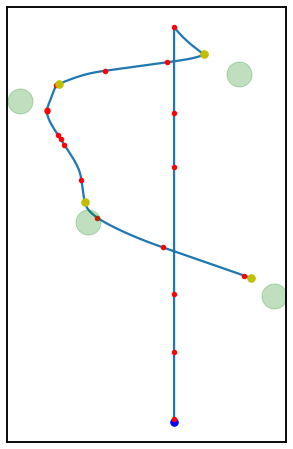

In [89]:
# Plot an encoding trial: with traversals, chest locations, and spike firing
# TODO: add stimulus and event happenings to `plot_positions` & use that here
_, ax = plt.subplots(figsize=(5, 8))
ax.plot(*t_pos)
ax.plot(*t_pos[:, 0], 'b.', ms=15)
ax.plot(t_spike_xs, t_spike_ys, '.r')
[ax.plot(*cht, 'y.', ms=15) for cht in ch_times];
ax.plot(chest_xs[t_mask], chest_ys[t_mask], '.g', ms=50, alpha=0.25)
ax.set_xticklabels([]); ax.set_yticklabels([]);
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Serial Position

In [219]:
# Get the length of time between segments (chest openings)
seg_times = np.diff(np.insert(ch_openings, 0, t_time[0]))

In [137]:
# Count firing in each segment, and compute firing rate
count = Counter({0 : 0, 1 : 0, 2 : 0, 3 : 0})
count.update(np.digitize(t_spikes, ch_openings))
inds = count.keys()
frs = np.array(list(count.values())) / seg_times * 1000

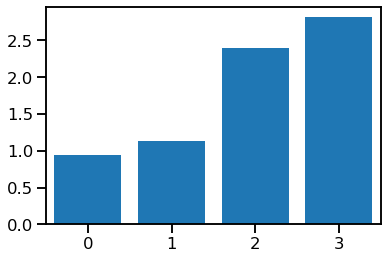

In [92]:
# Plot firing rate per segment (single trial)
plot_bar(frs, inds)

In [103]:
# Compute firing rates per segment for all trials
all_frs = compute_serial_position_fr(spikes, trial_starts, chest_openings, chest_trials, ptimes, positions)

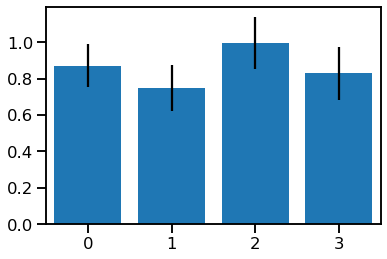

In [104]:
# Plot firing rates per segment across all trials
plot_bar(all_frs.mean(0), inds, yerr=sem(all_frs, 0))

In [96]:
# Create shuffled time series for comparison
#   Note: some temporary quirks here to deal with UNIX time
temp = spikes - st
times_shuffle = shuffle_spikes(temp, shuffle_approach, n_surrogates)
times_shuffle = times_shuffle + st

In [182]:
# compute the firing rate per segement across trials on surrogates
all_surrs = np.zeros(shape=[n_surrogates, 4])
for ind, stimes in enumerate(times_shuffle):
    surrs_frs = compute_serial_position_fr(stimes, trial_starts, chest_openings, chest_trials, ptimes, positions) 
    
    # Take the mean across trials of shuffle n
    mean_surrs = np.mean(surrs_frs, 0)
    
    # Collect the mean of shuffle n
    all_surrs[ind] = mean_surrs

In [214]:
# Compute the empirical p-value based on surrogates for each segment (seg1, seg2, seg3, seg4)
surr_p_val_seg1 = compute_empirical_pvalue(all_frs.mean(0)[0],all_surrs[:,0])
surr_p_val_seg2 = compute_empirical_pvalue(all_frs.mean(0)[1],all_surrs[:,1])
surr_p_val_seg3 = compute_empirical_pvalue(all_frs.mean(0)[2],all_surrs[:,2])
surr_p_val_seg4 = compute_empirical_pvalue(all_frs.mean(0)[3],all_surrs[:,3])

# Compute z-score compared to surrogates for each segment (seg1, seg2, seg3, seg4)
z_score_seg1 = zscore_to_surrogates(all_frs.mean(0)[0], all_surrs[:,0])
z_score_seg2 = zscore_to_surrogates(all_frs.mean(0)[1], all_surrs[:,1])
z_score_seg3 = zscore_to_surrogates(all_frs.mean(0)[2], all_surrs[:,2])
z_score_seg4 = zscore_to_surrogates(all_frs.mean(0)[3], all_surrs[:,3])

In [270]:
# Collect surr_p_val and z-score from each segment
surr_p_val_all = np.array([surr_p_val_seg1,surr_p_val_seg2,surr_p_val_seg3,surr_p_val_seg4])
z_score_all = np.array([z_score_seg1,z_score_seg2,z_score_seg3,z_score_seg4])

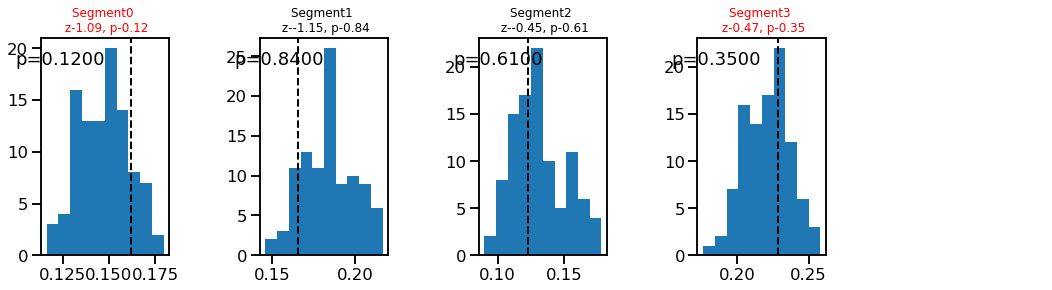

In [268]:
# Plot distribution of surrogates with measured empirical value for each segment (seg1, seg2, seg3, seg4)
for ii, ax in zip(range(4), make_axes(4, hspace=0.2, wspace=0.7)):
    plot_surrogates(all_surrs[:,ii], all_frs.mean(0)[ii], surr_p_val_all[ii], ax=ax)
    
    color = 'red' if surr_p_val_all[ii] < 0.5 else 'black'
    title = 'Segment{} \n z-{:1.2f}, p-{:1.2f}'.format(ii, z_score_all[ii], surr_p_val_all[ii])
    ax.set_title(title, fontdict={'fontsize' : 12}, color=color);

# All Cells

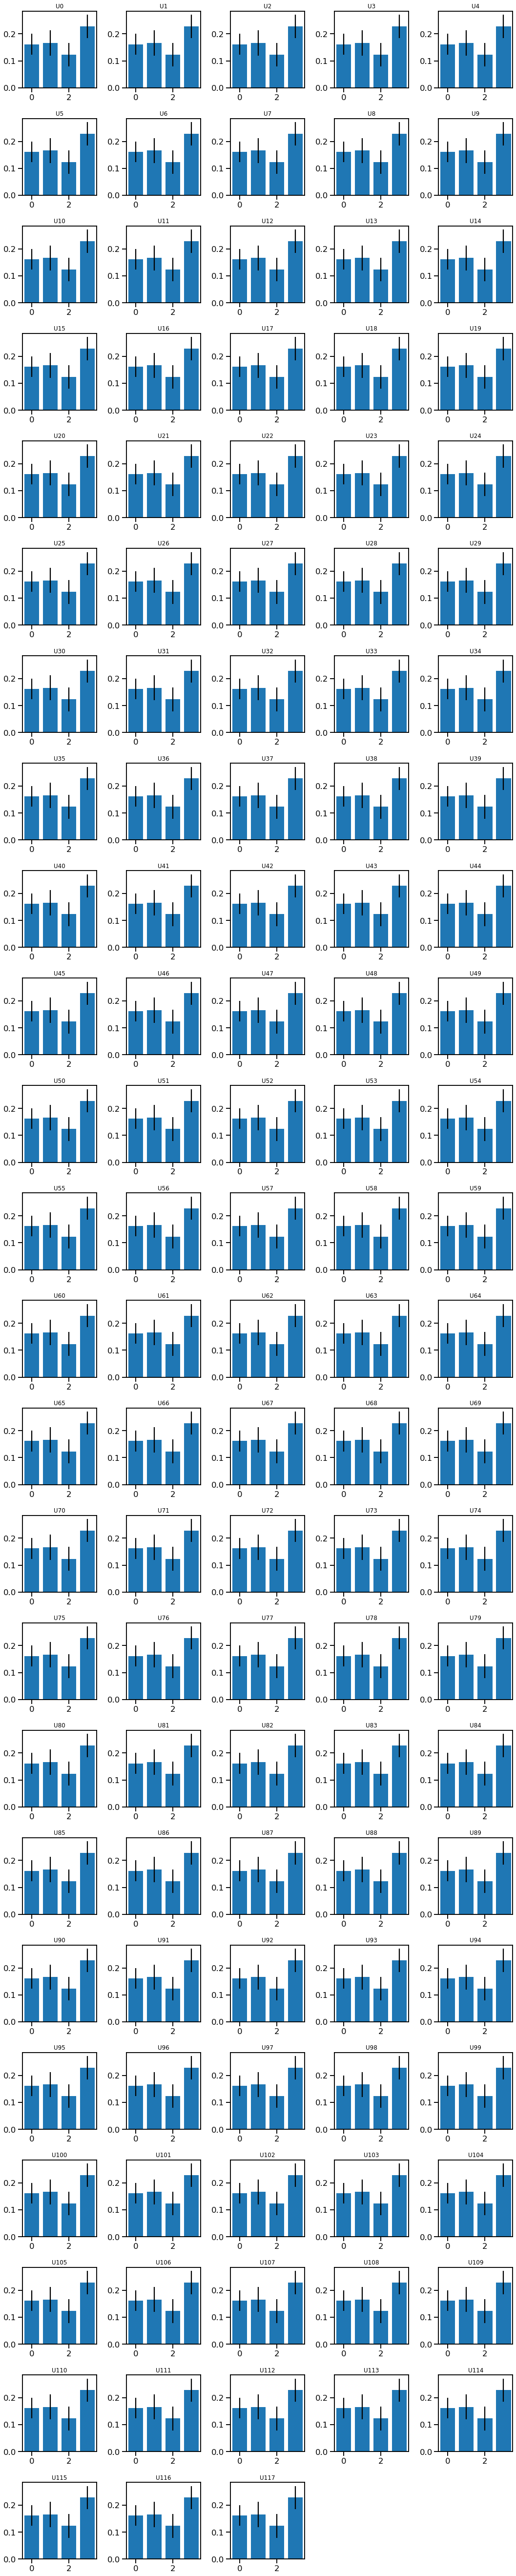

In [249]:
# Plot the firing rate per segment across trials for all units 

for ii, ax in zip(range(n_units), make_axes(n_units, hspace=0.4, wspace=0.4)):
    spikes = nwbfile.units.get_unit_spike_times(uint) / 1000
    spikes = restrict_range(spikes, st, en)
    
    seg_times = np.diff(np.insert(ch_openings, 0, t_time[0]))
    
    # Count firing in each segment, and compute firing rate
    count = Counter({0 : 0, 1 : 0, 2 : 0, 3 : 0})
    count.update(np.digitize(t_spikes, ch_openings))
    inds = count.keys()
    frs = np.array(list(count.values())) / seg_times * 1000
    
    all_frs = compute_serial_position_fr(spikes, trial_starts, chest_openings, chest_trials, ptimes, positions)
    
    # Plot firing rates per segment across all trials
    plot_bar(all_frs.mean(0), inds, yerr=sem(all_frs, 0), ax=ax)
    title = 'U{}'.format(ii)
    ax.set_title(title, fontdict={'fontsize' : 12})

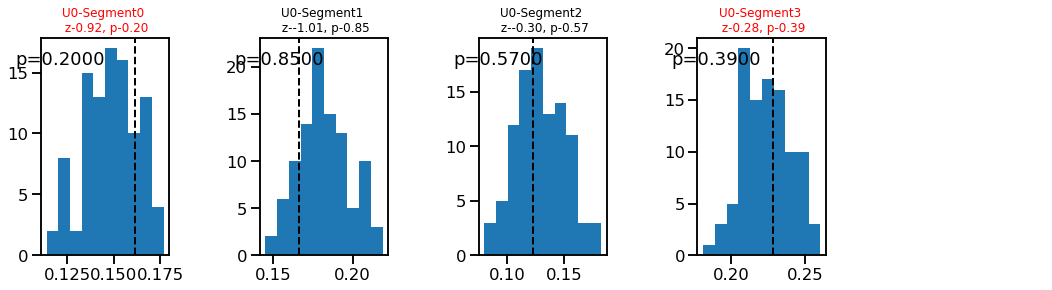

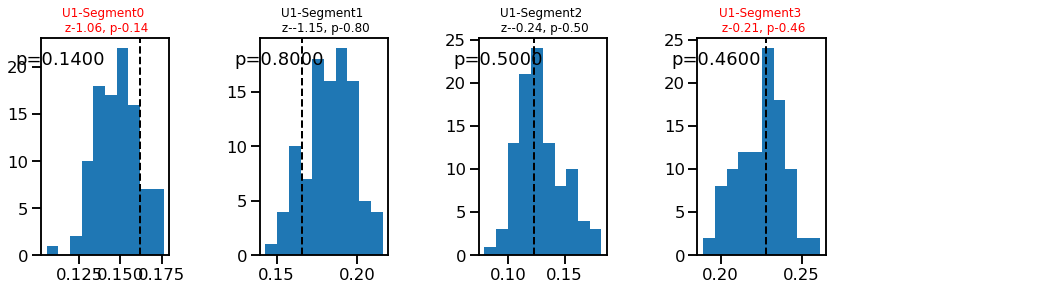

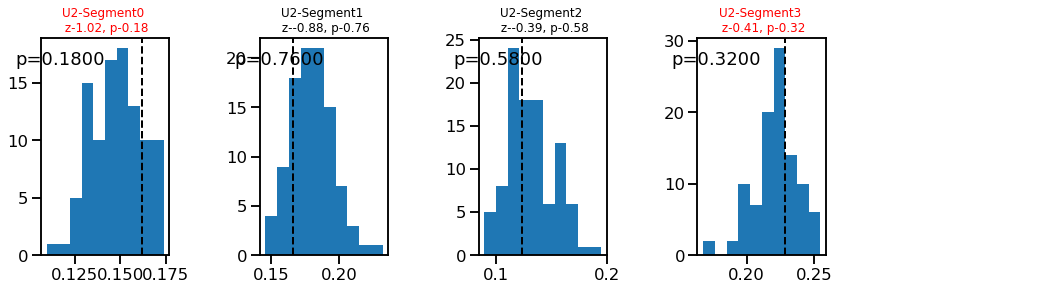

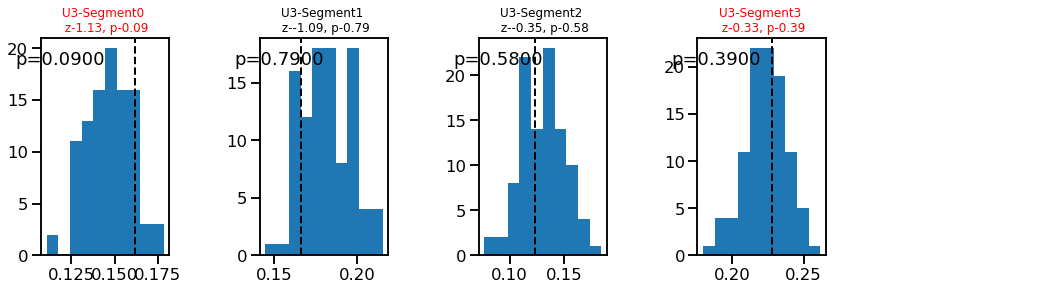

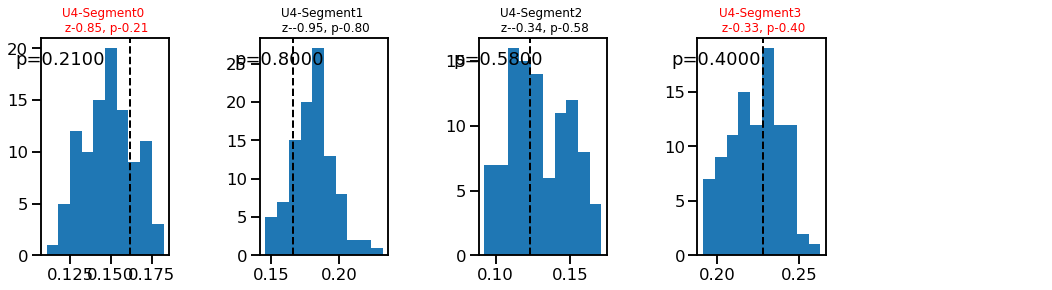

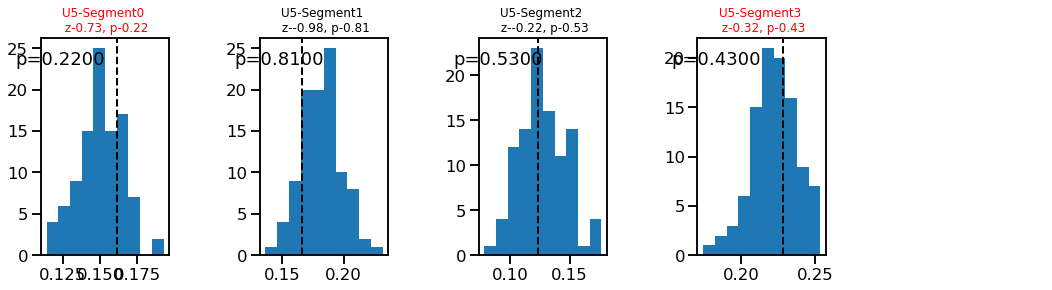

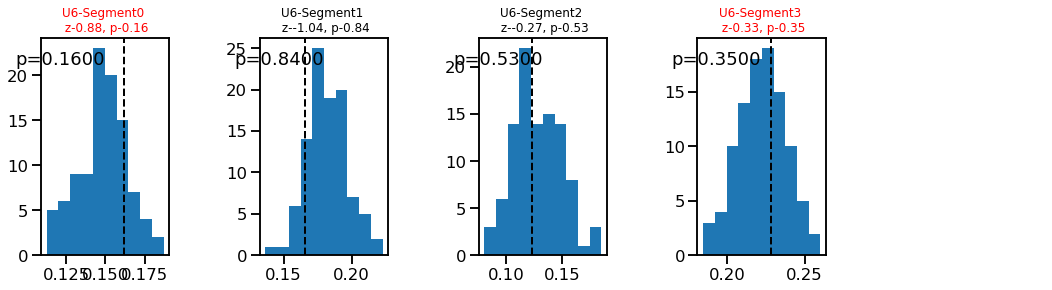

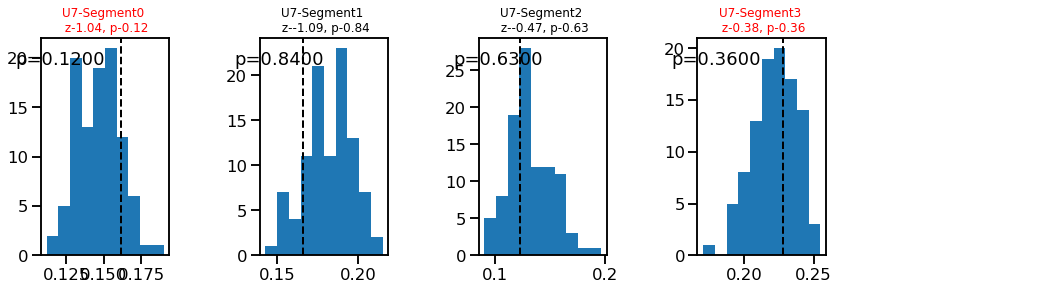

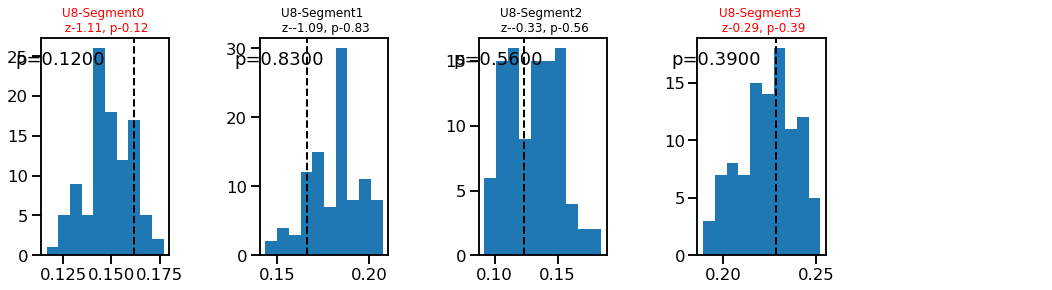

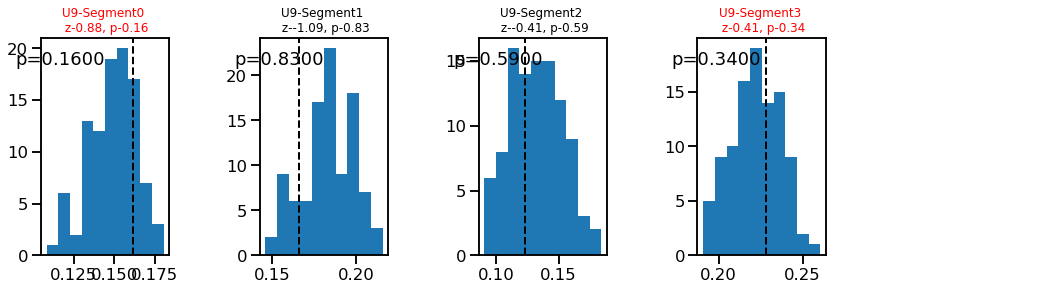

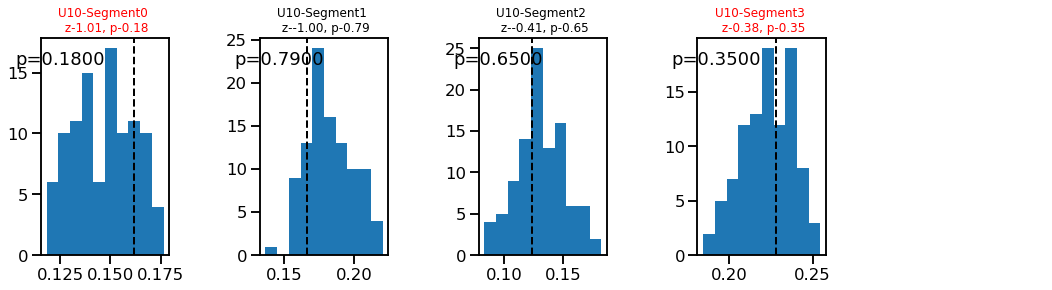

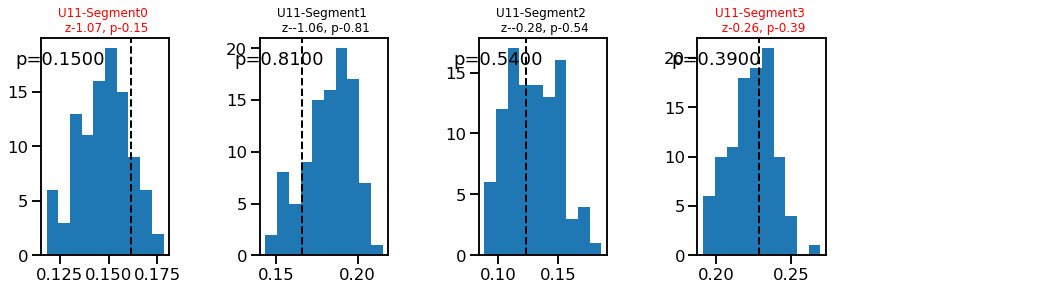

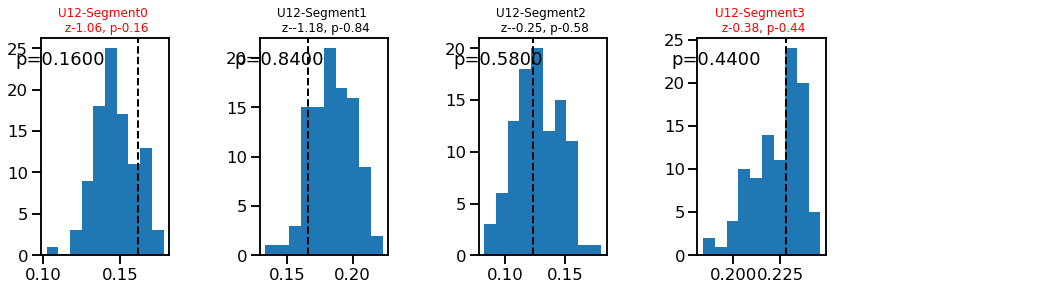

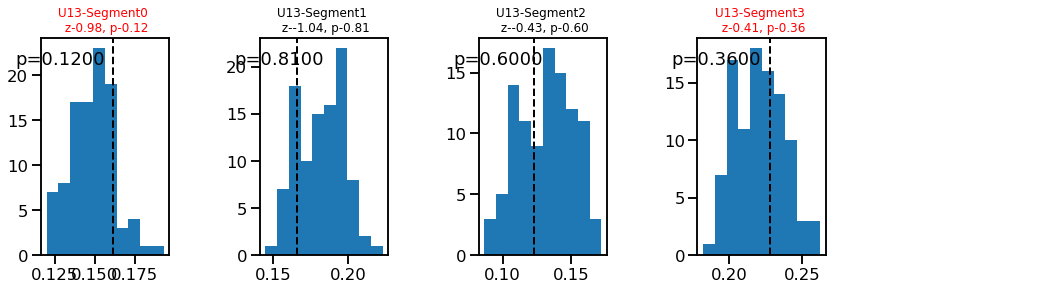

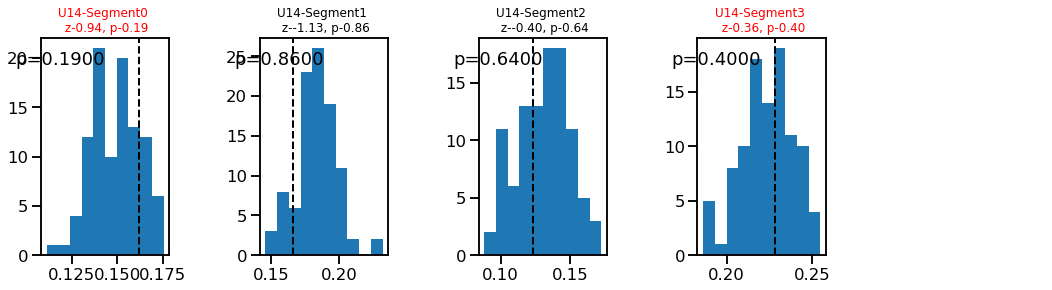

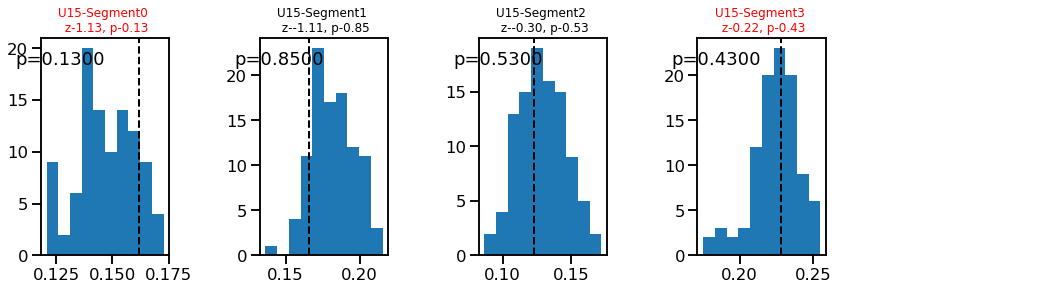

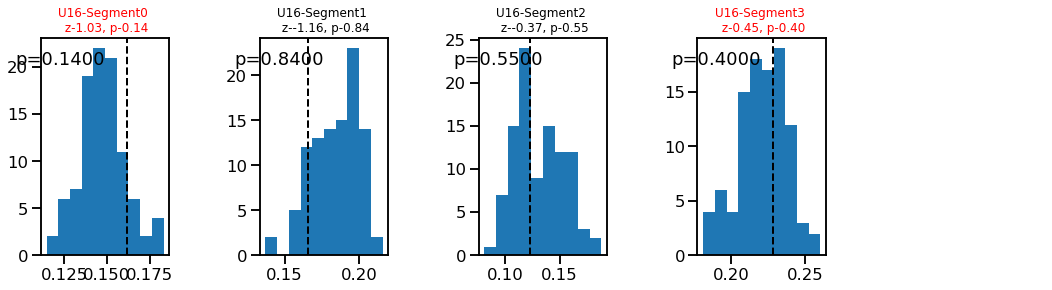

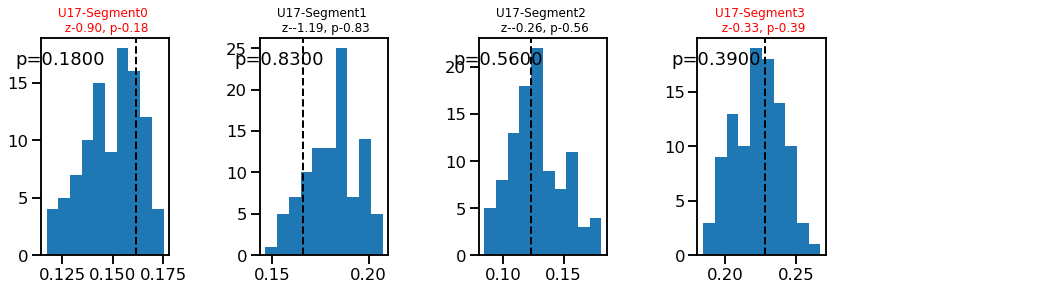

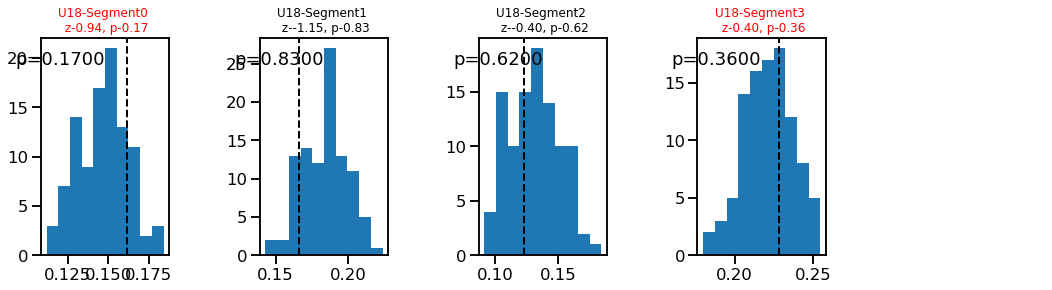

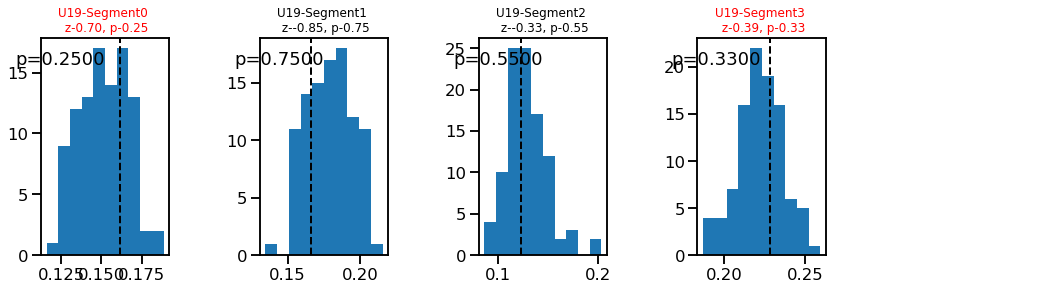

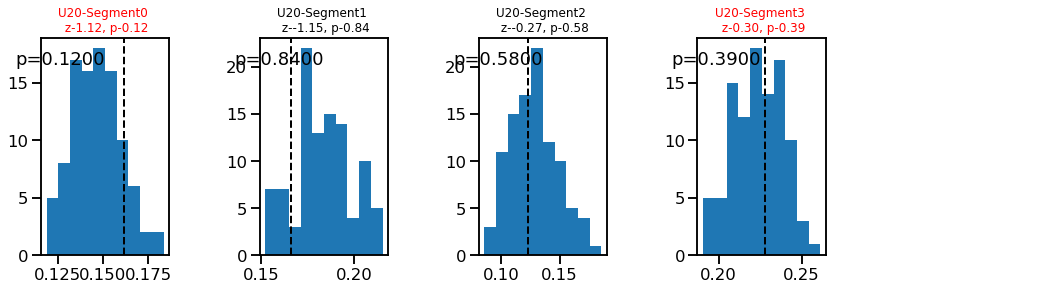

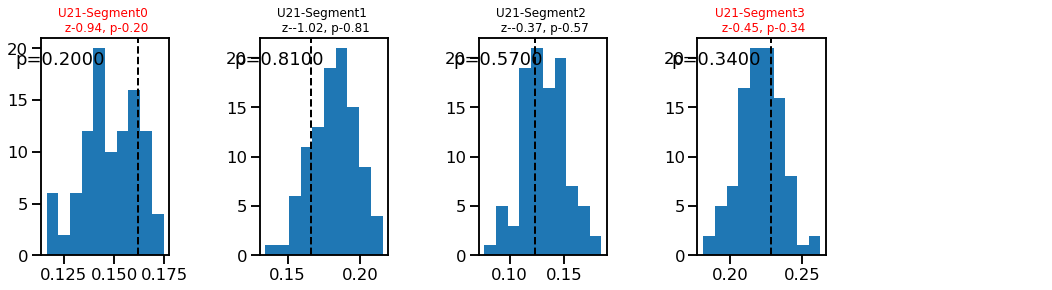

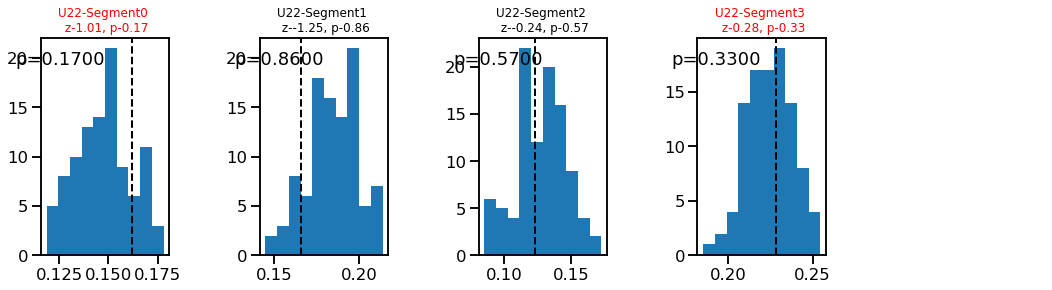

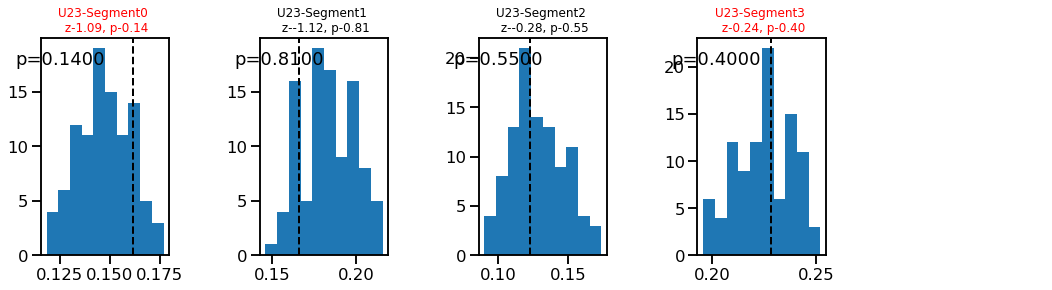

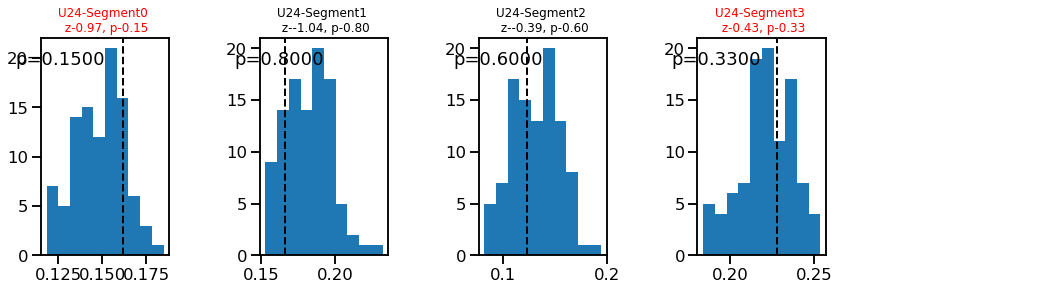

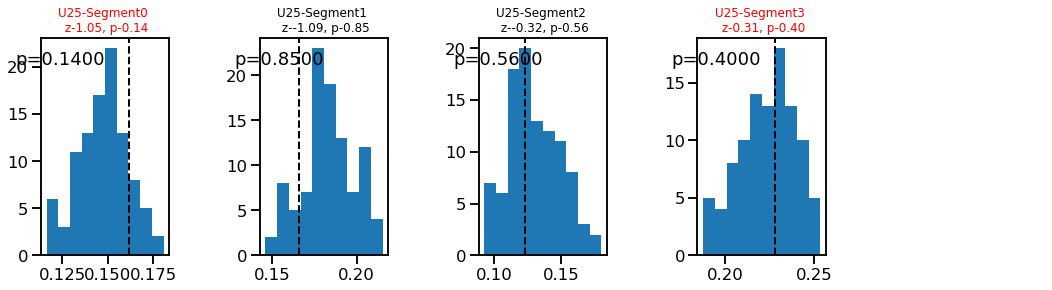

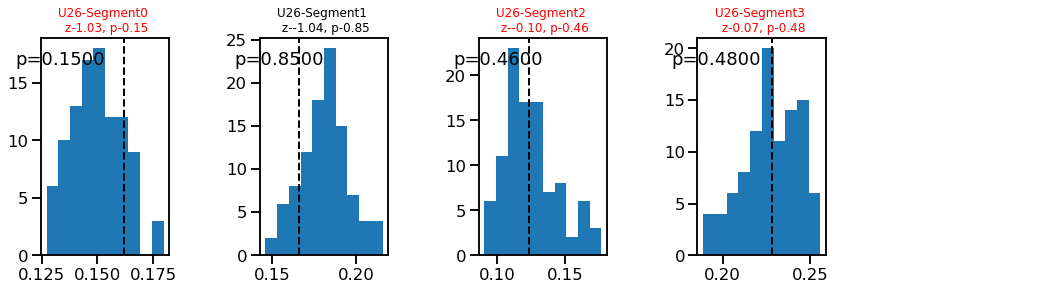

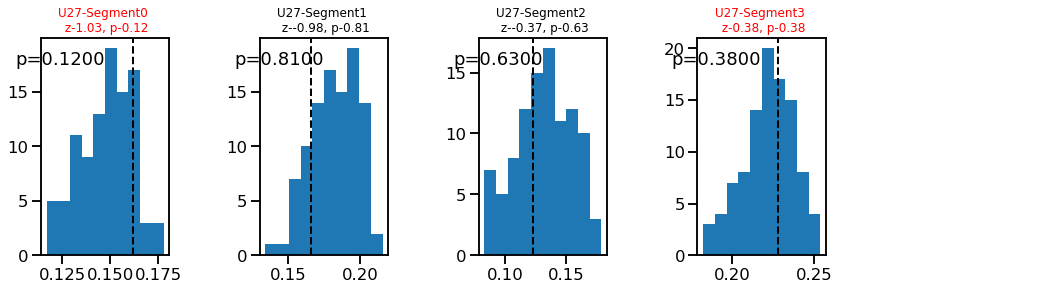

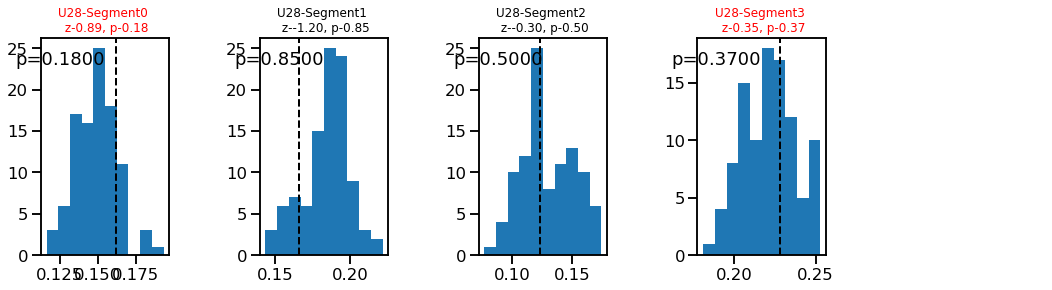

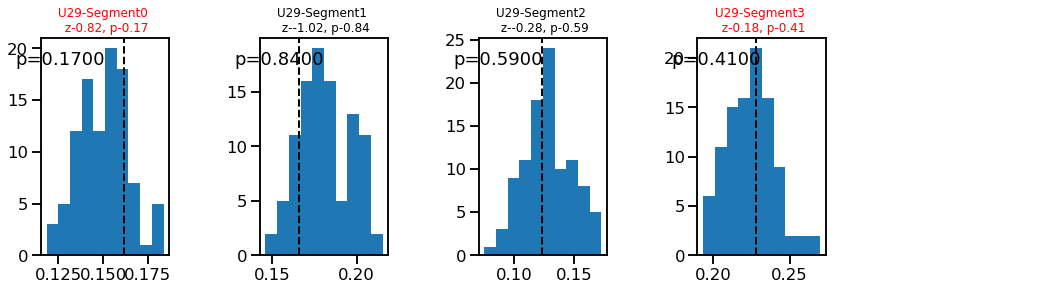

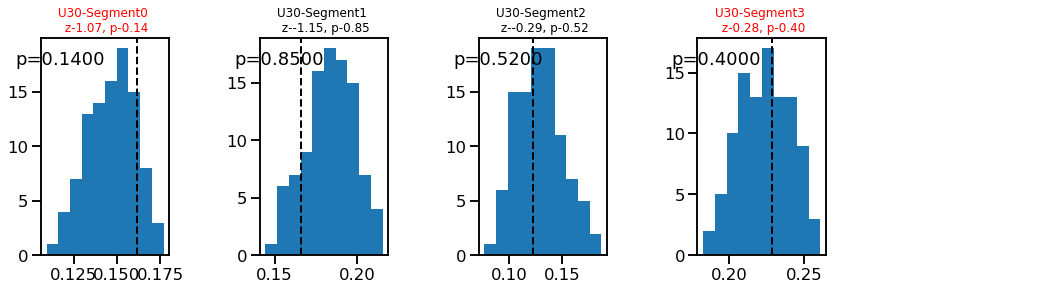

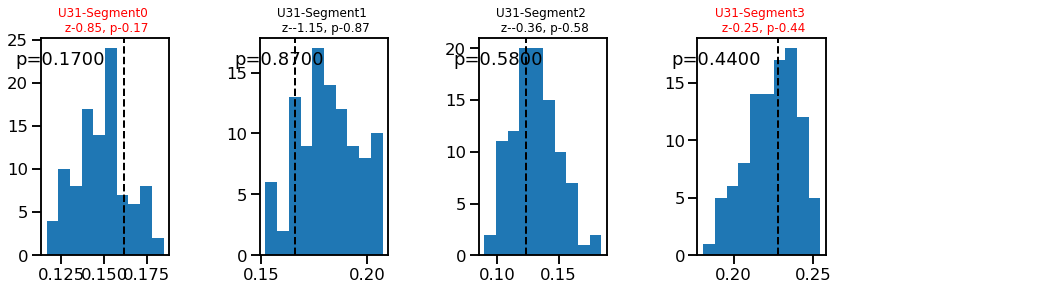

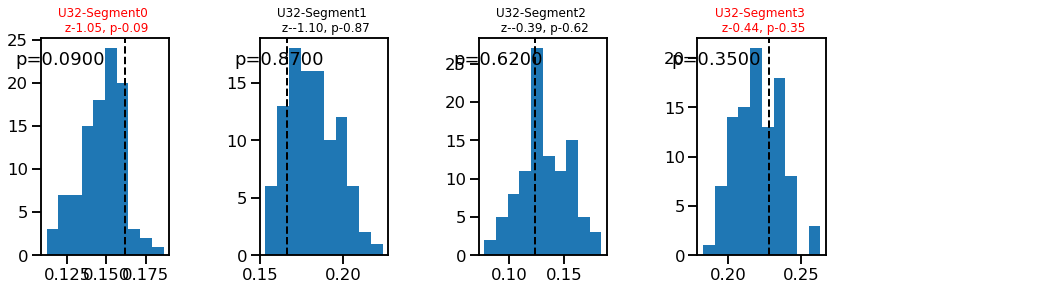

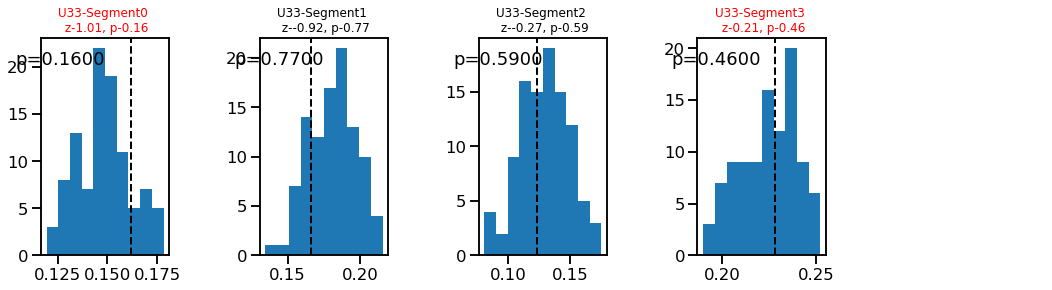

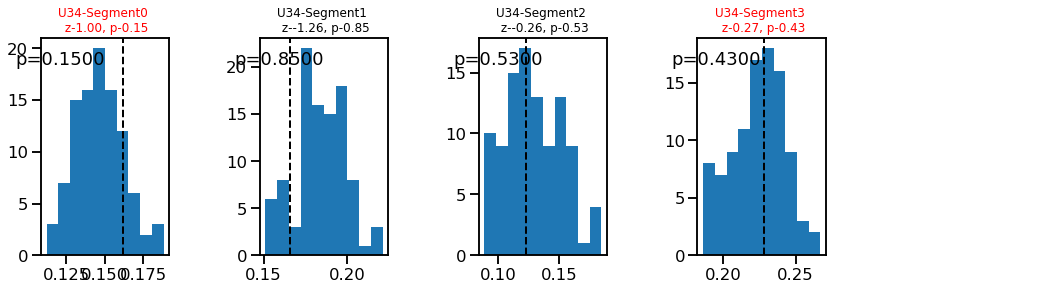

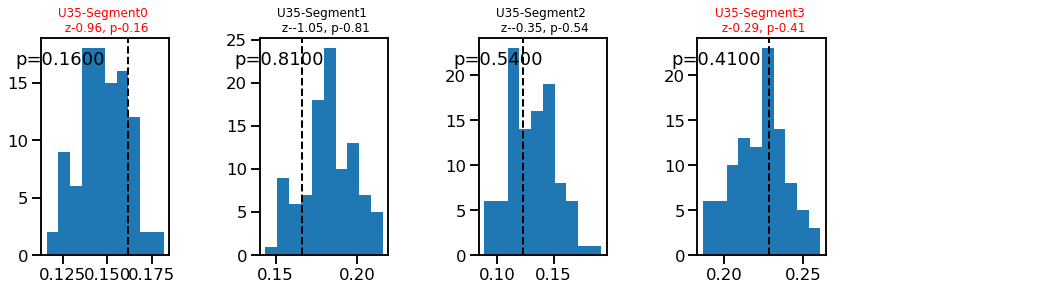

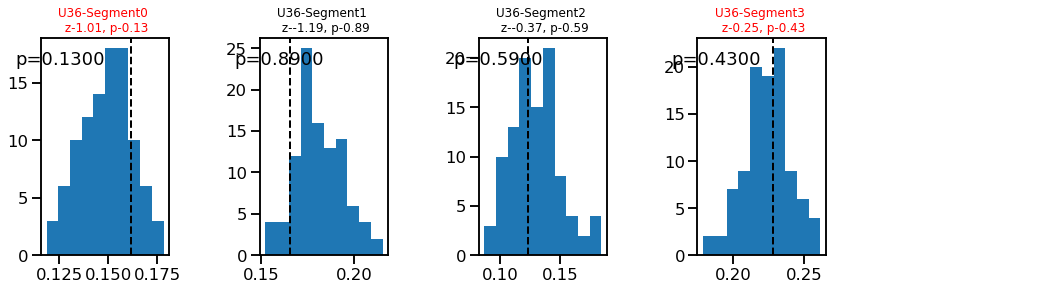

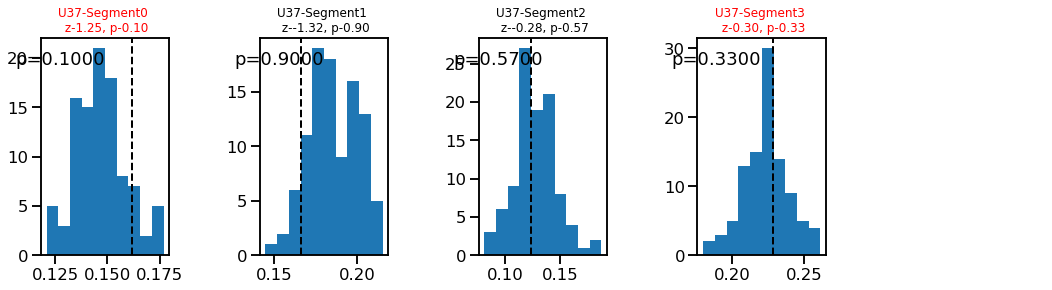

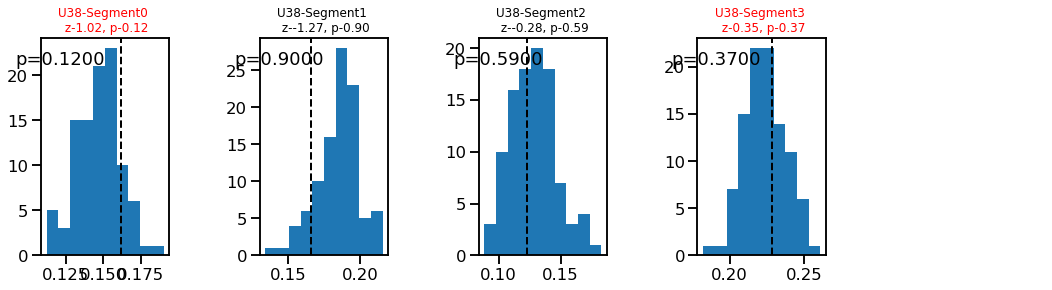

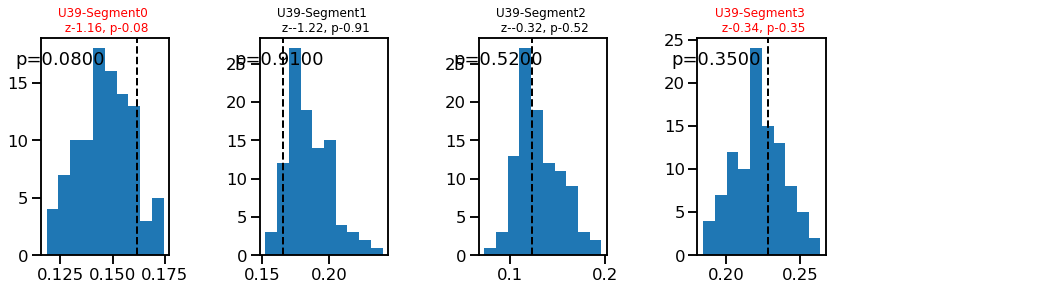

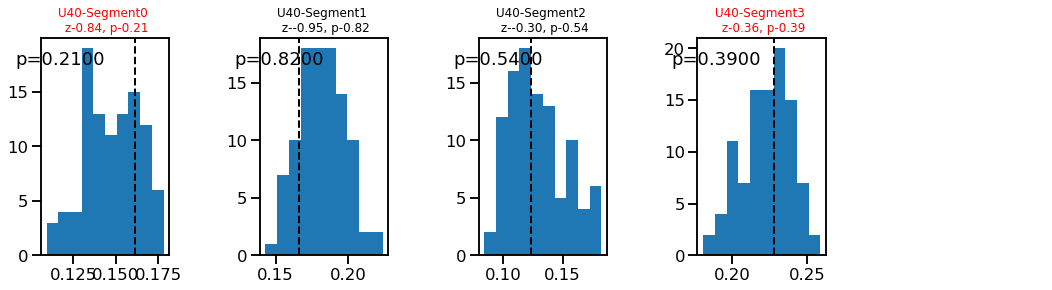

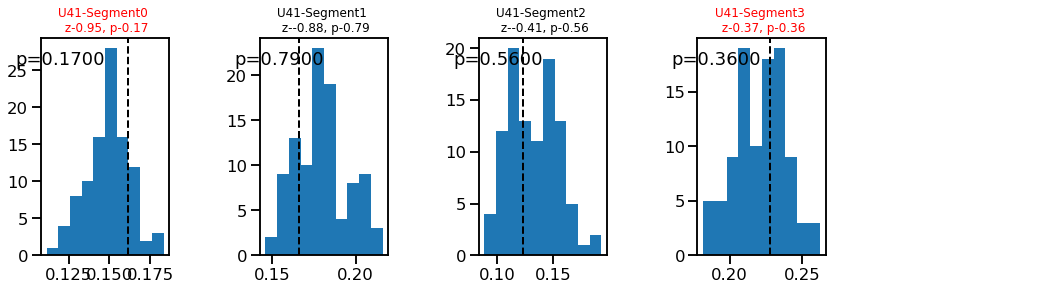

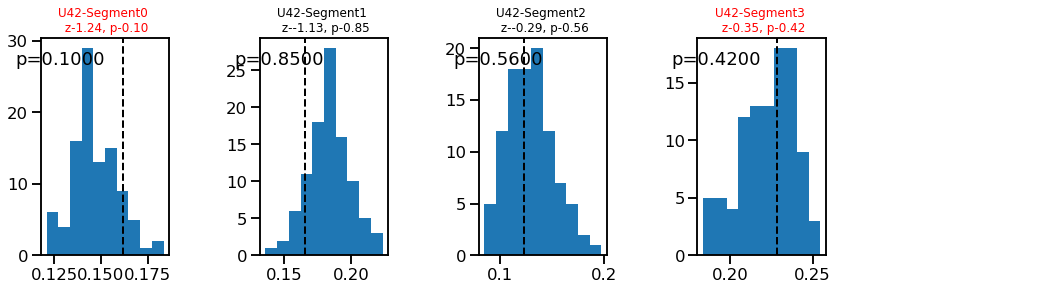

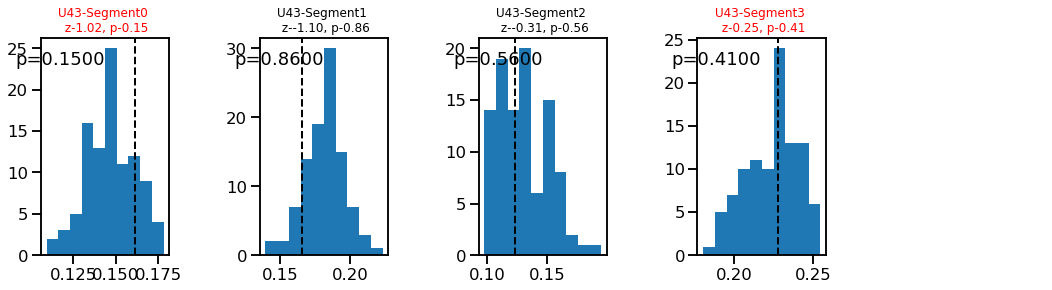

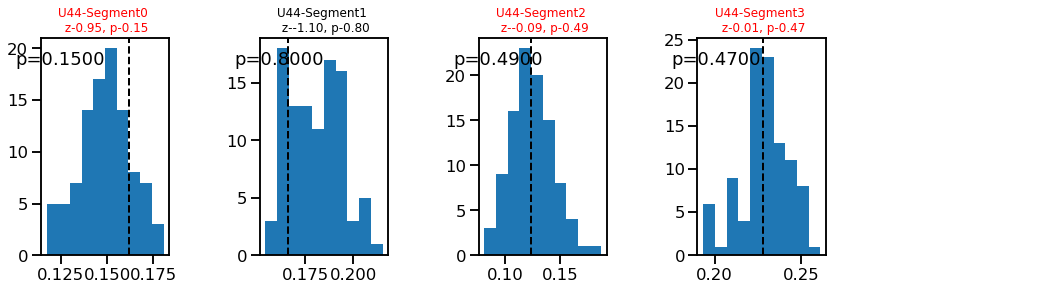

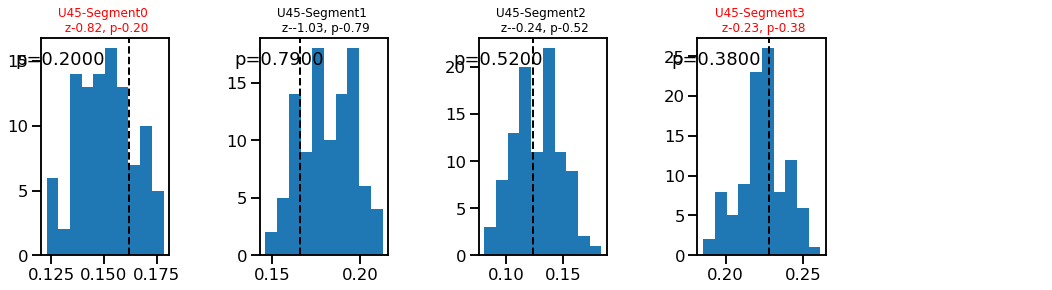

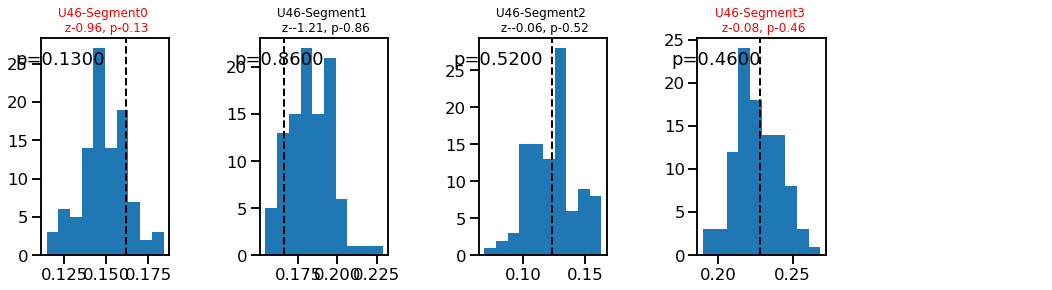

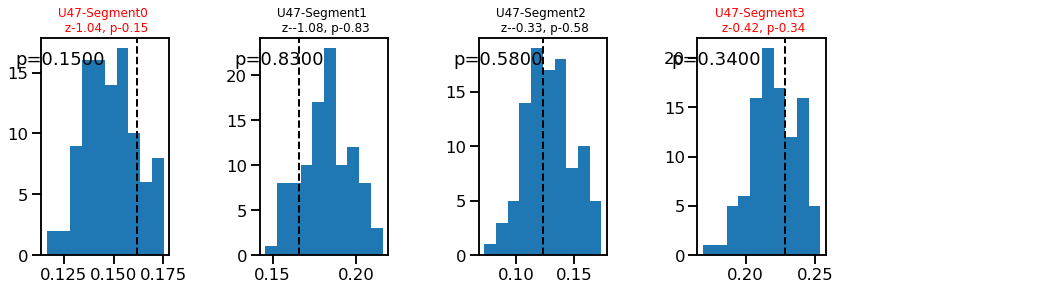

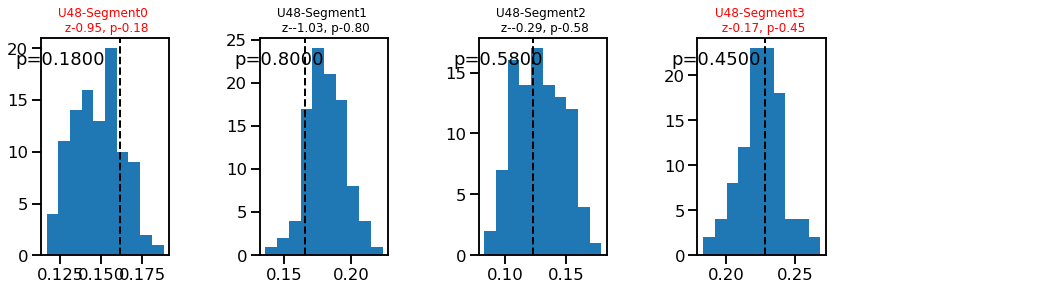

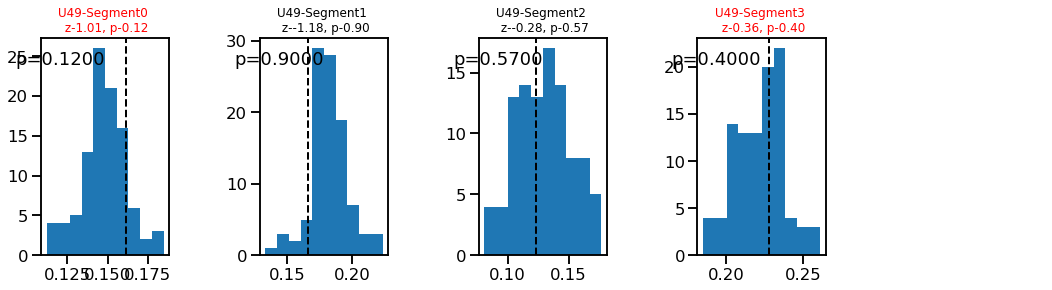

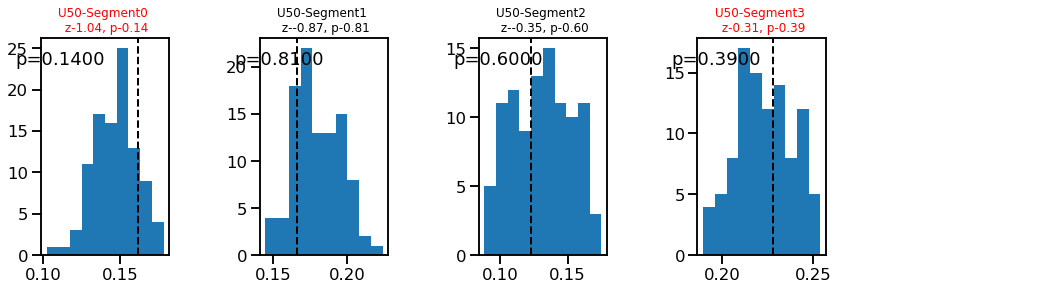

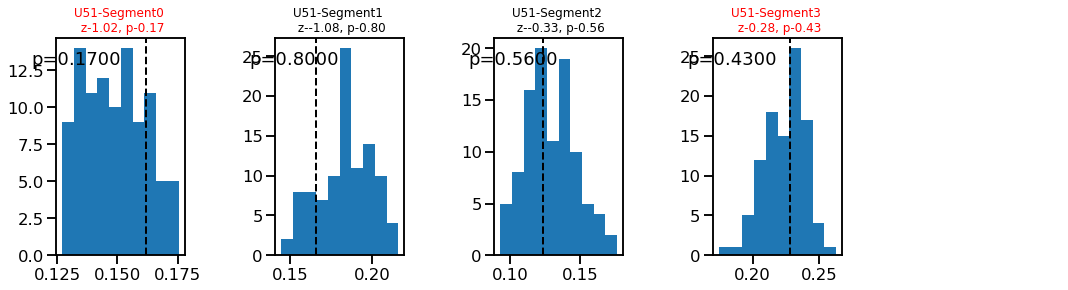

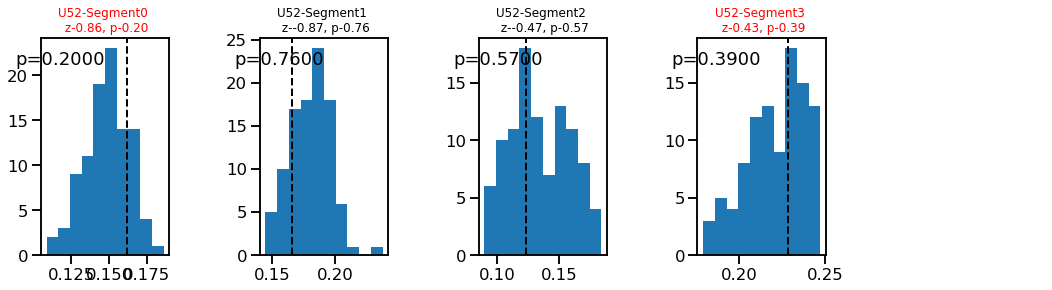

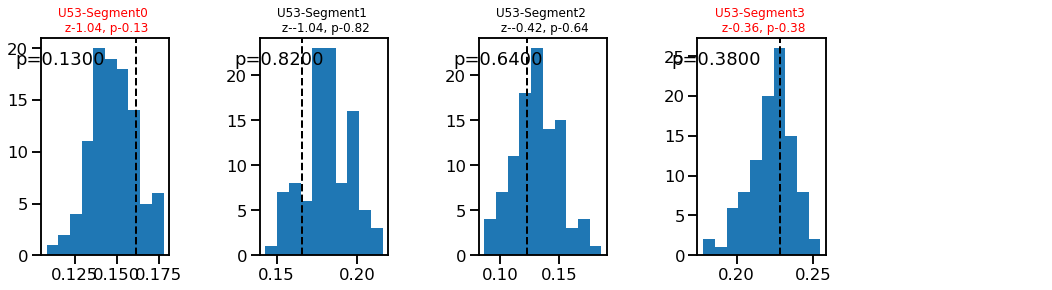

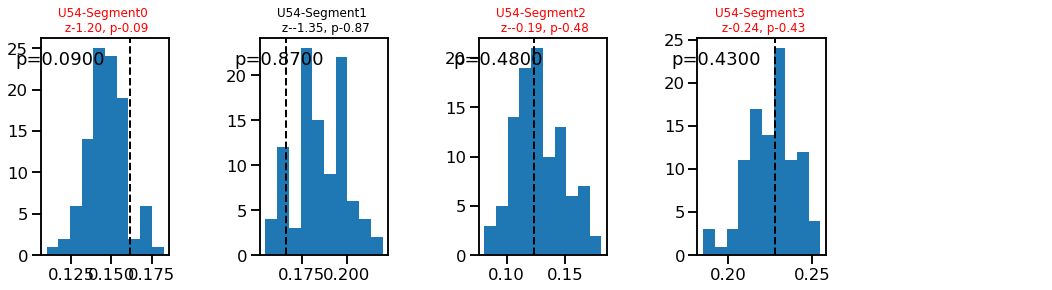

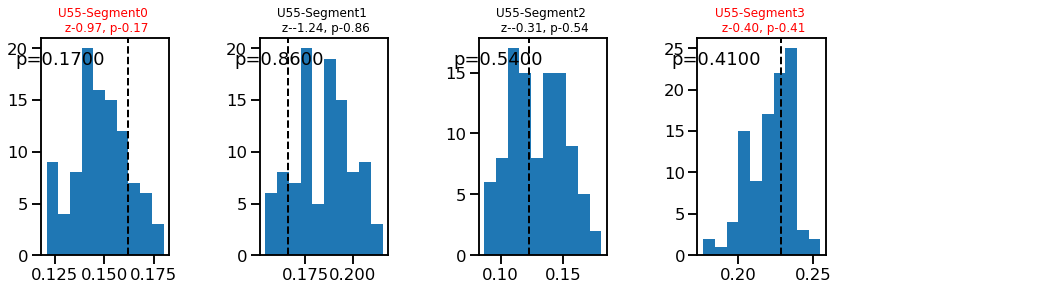

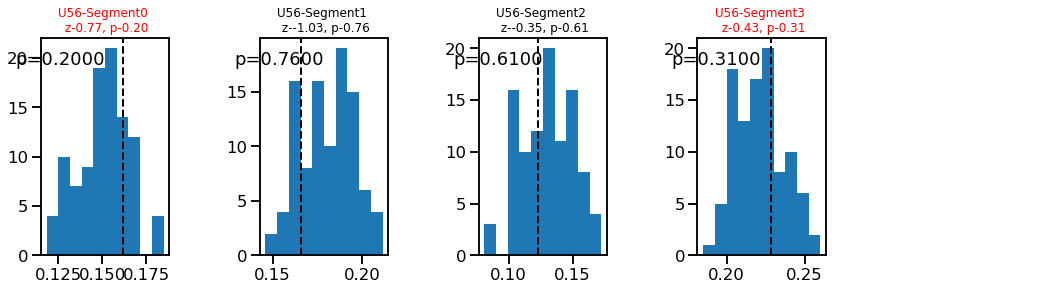

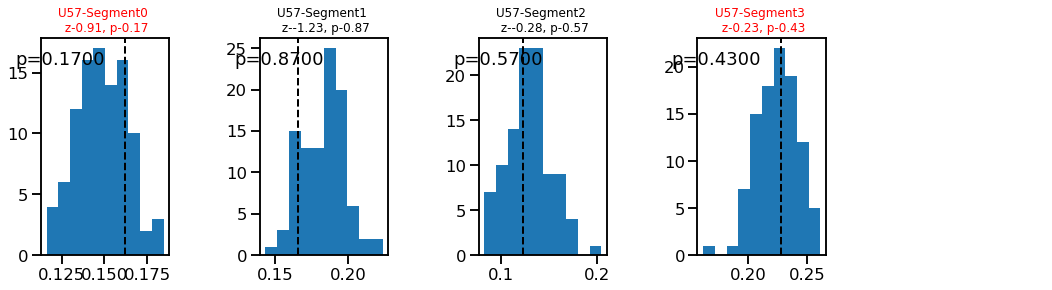

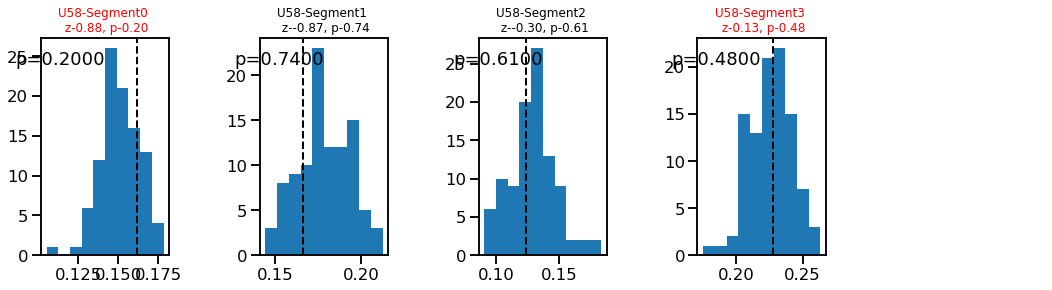

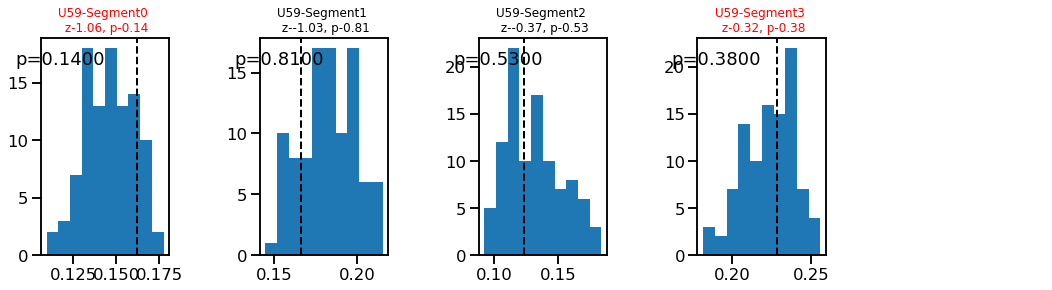

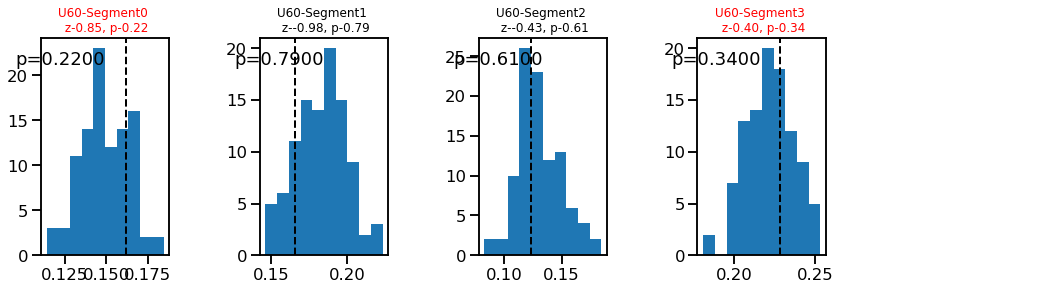

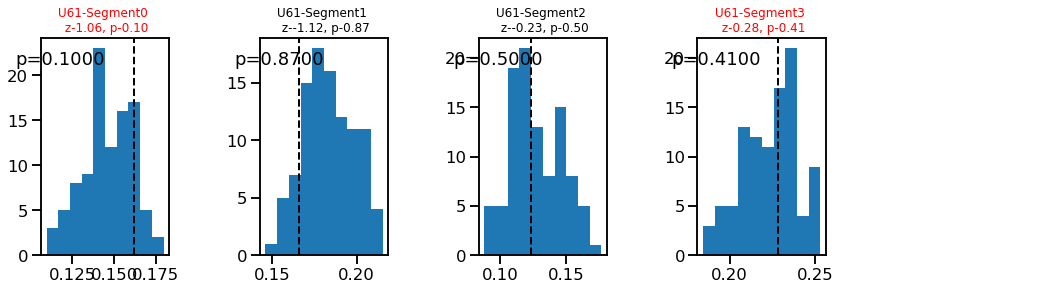

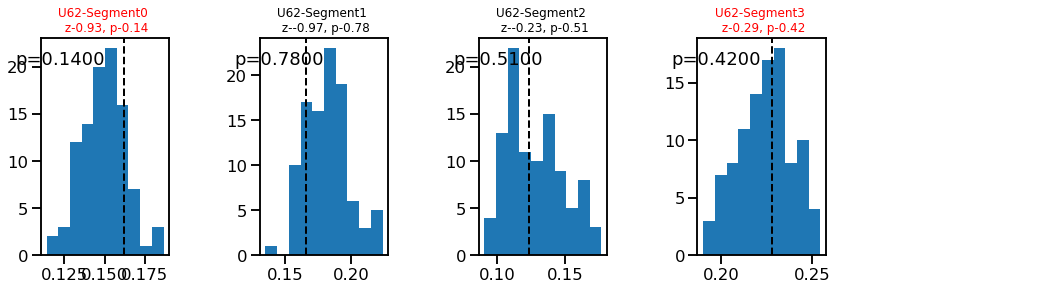

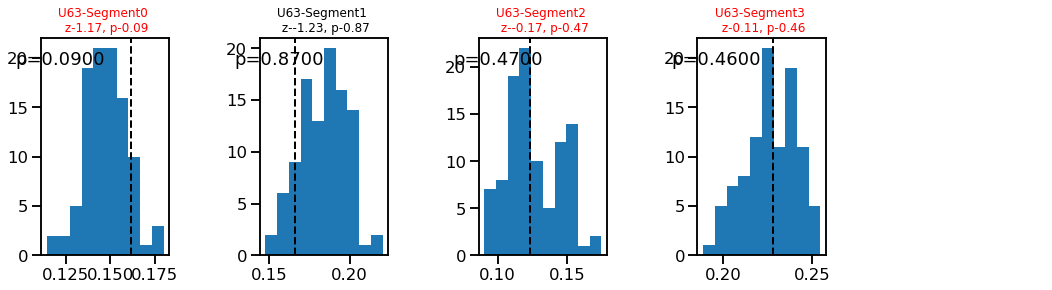

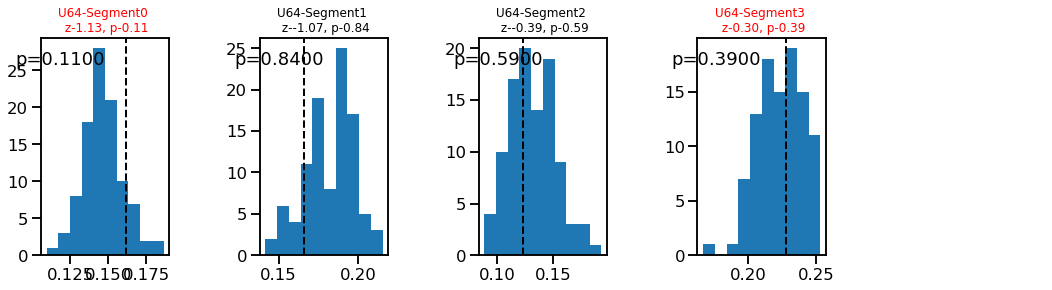

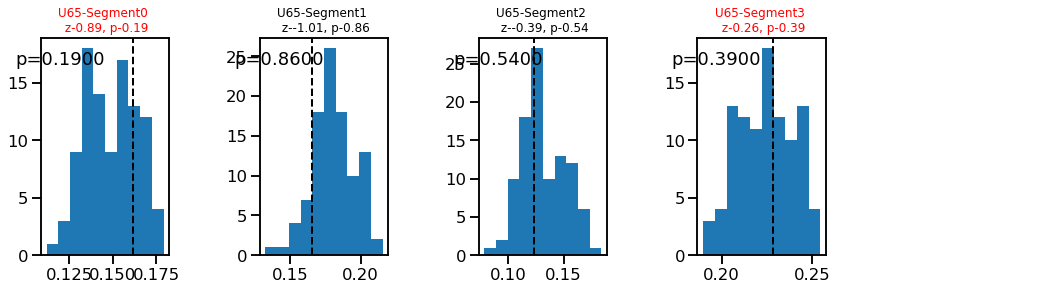

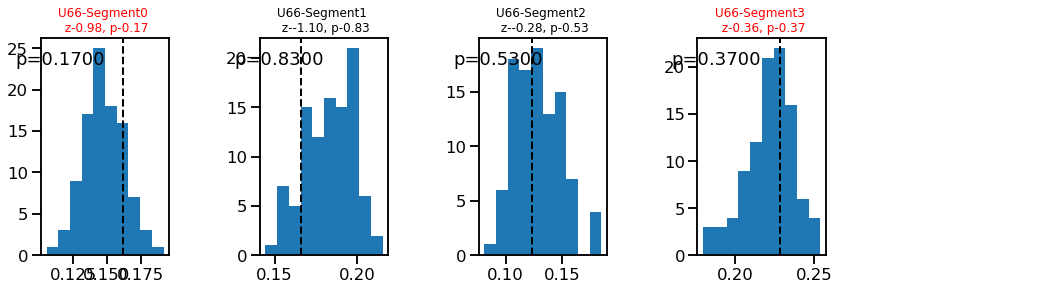

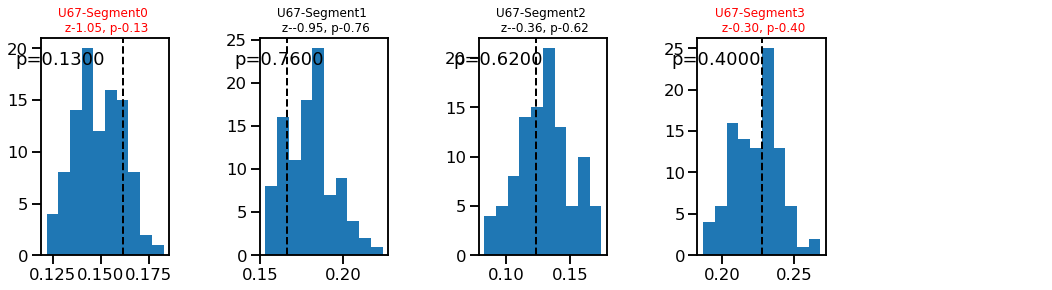

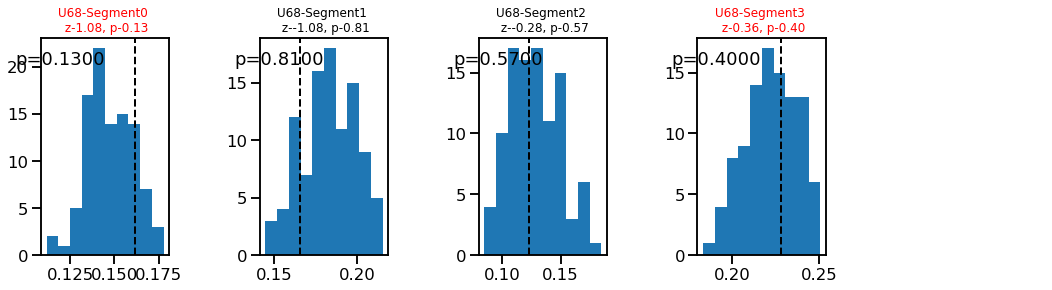

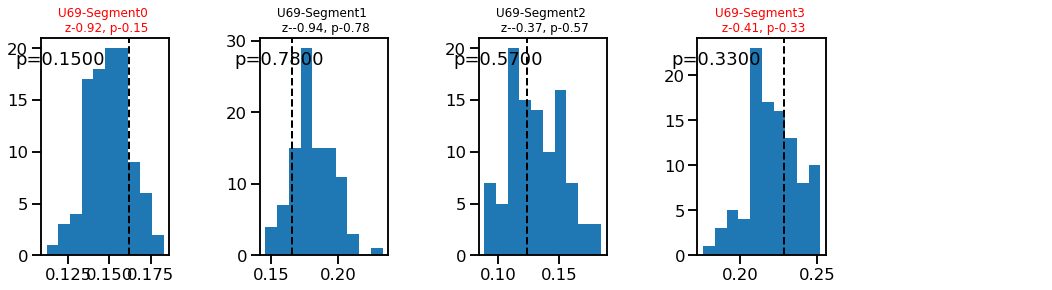

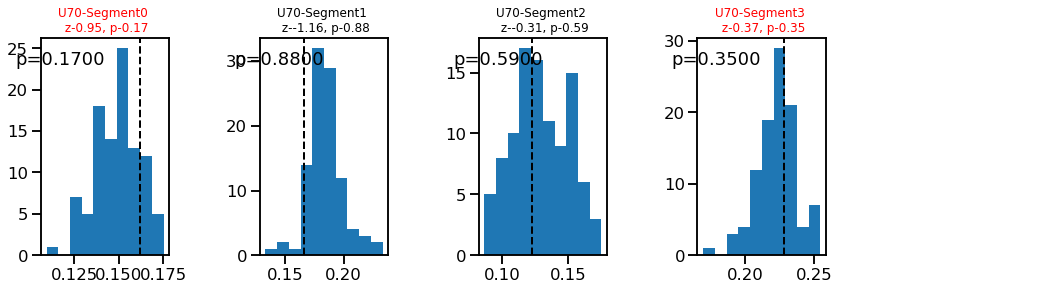

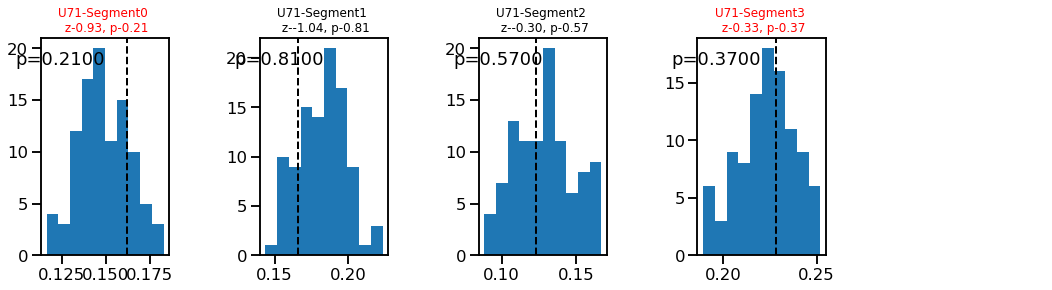

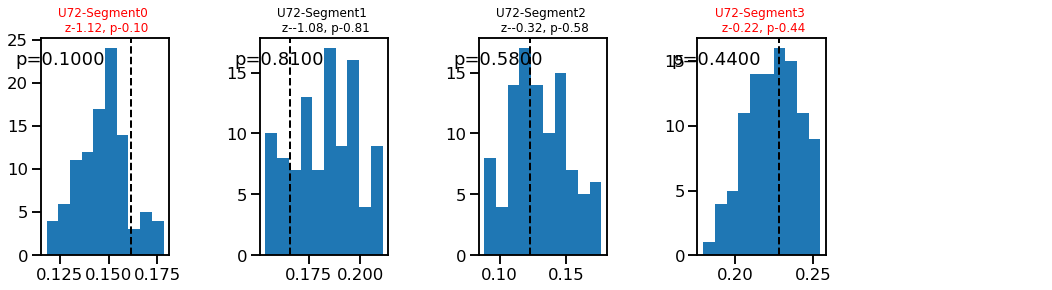

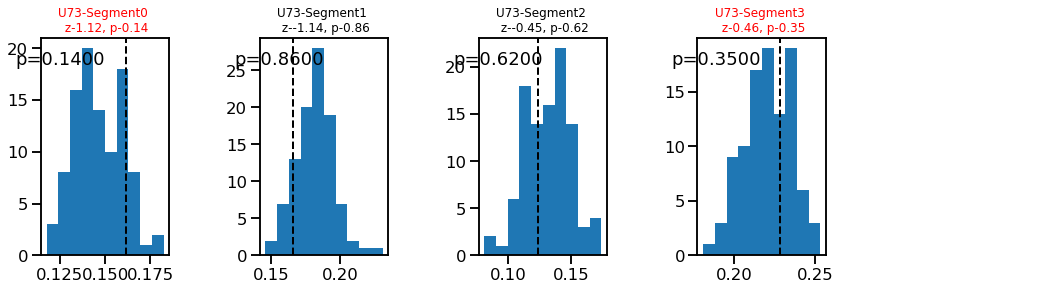

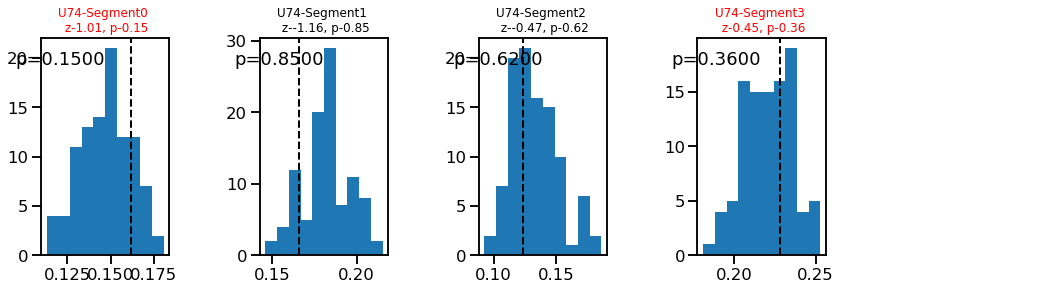

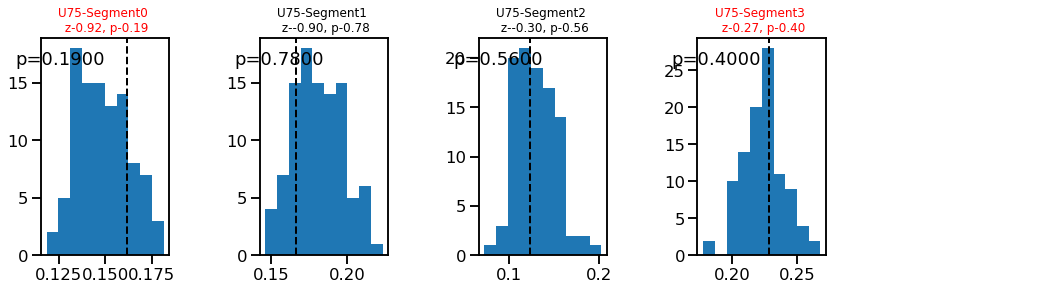

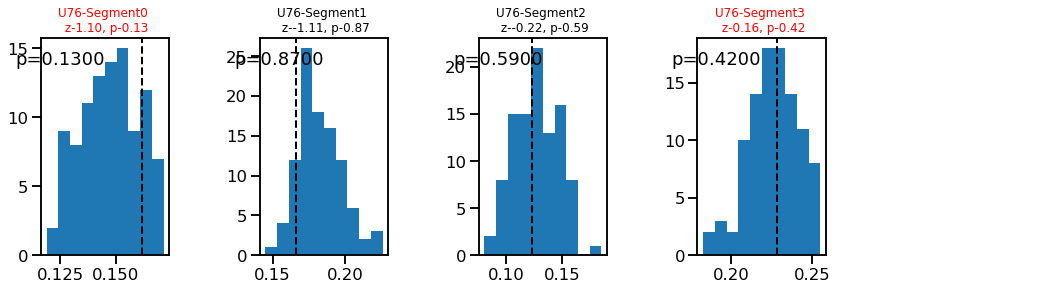

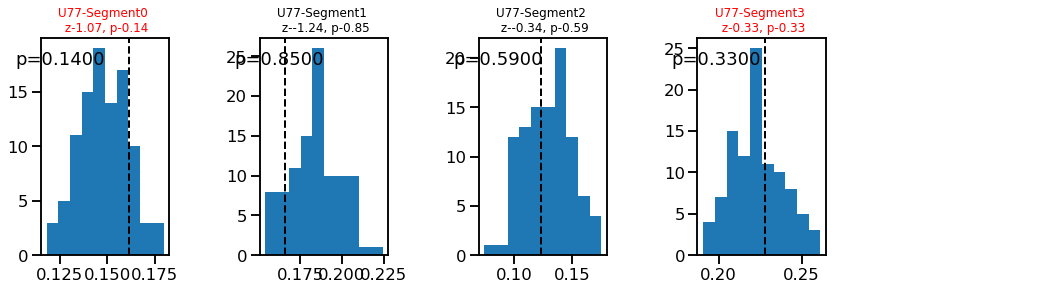

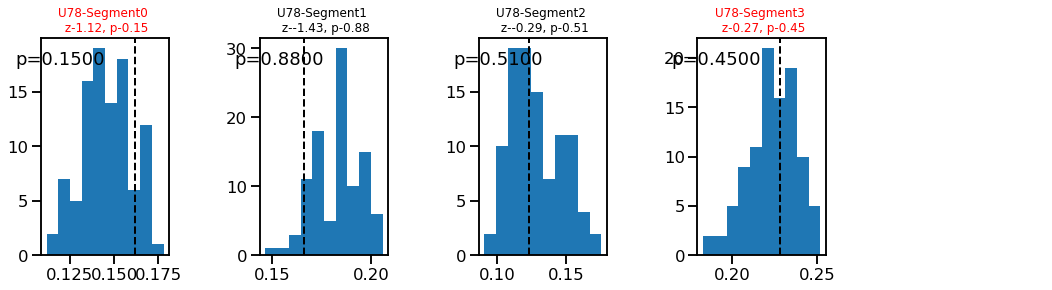

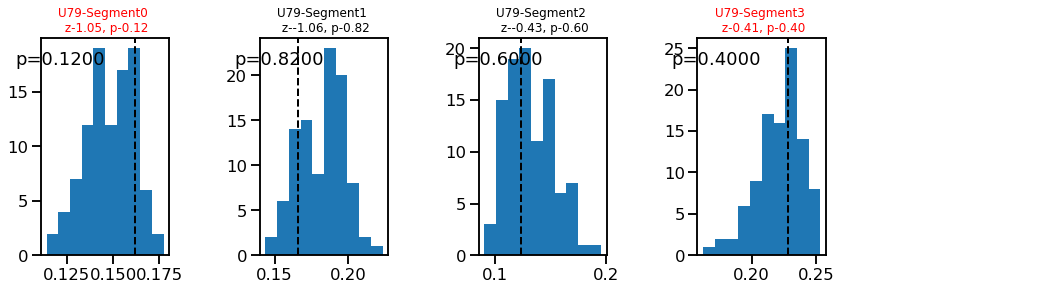

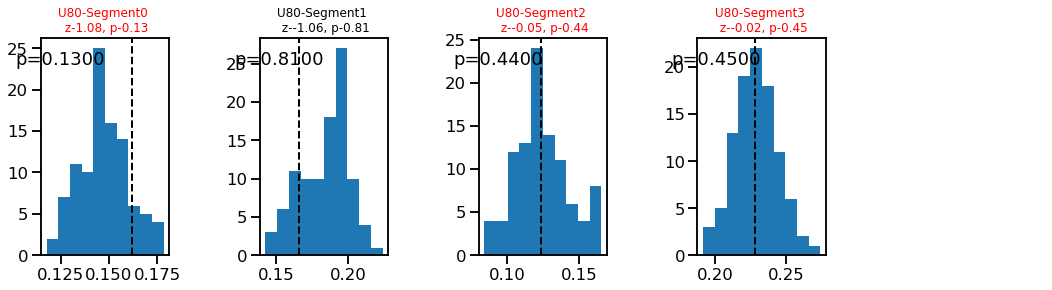

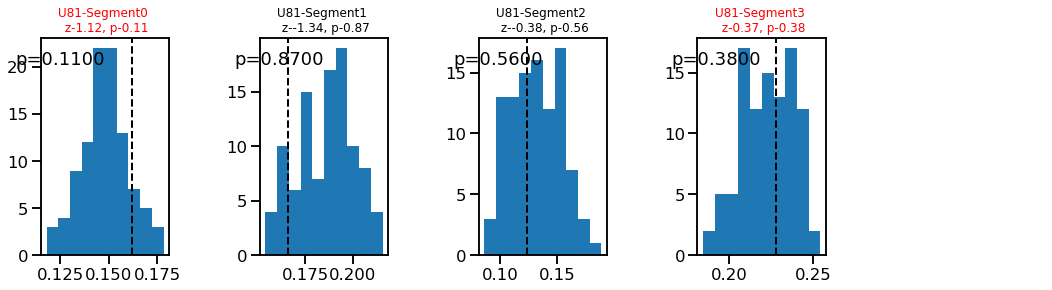

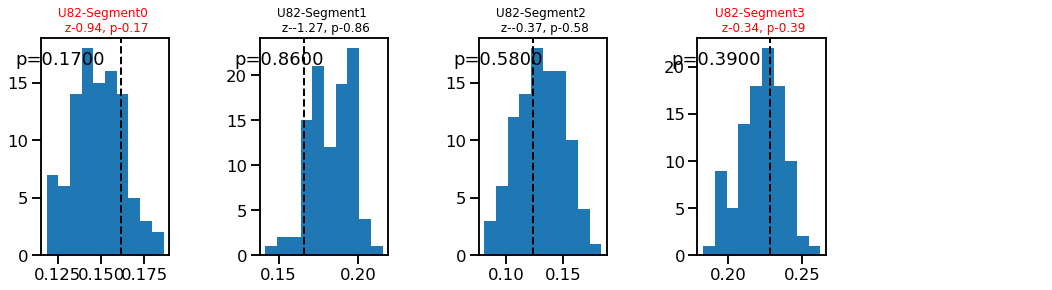

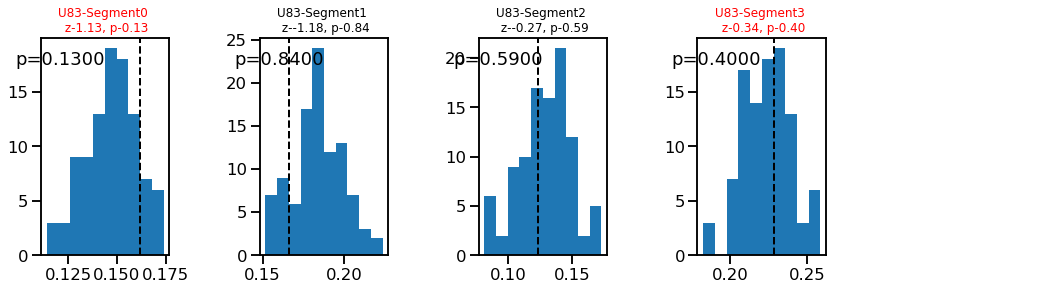

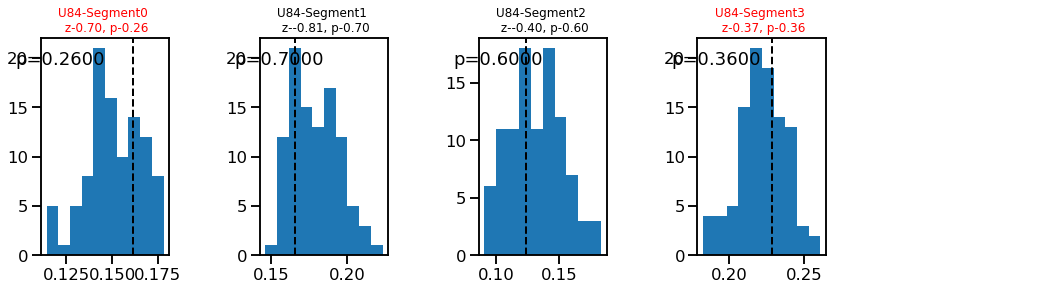

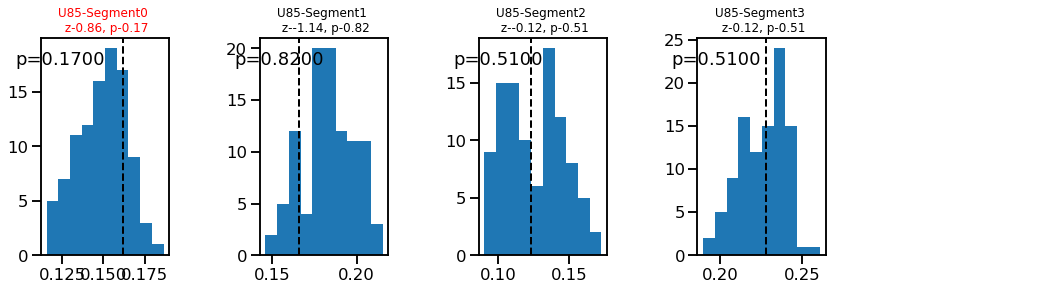

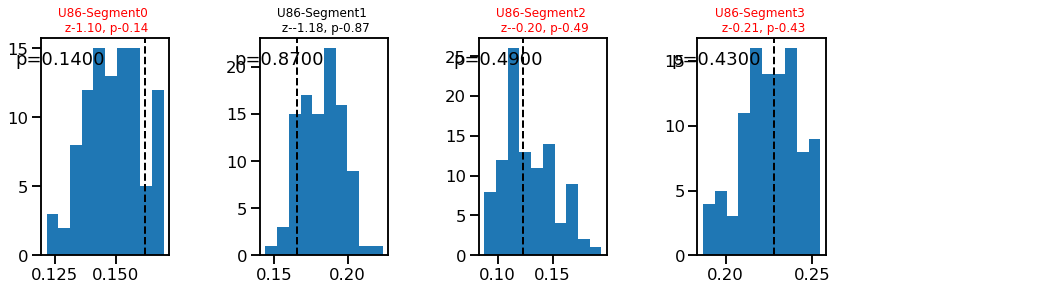

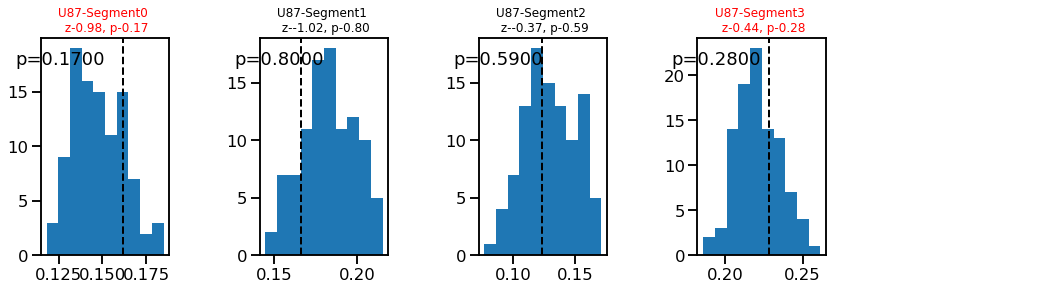

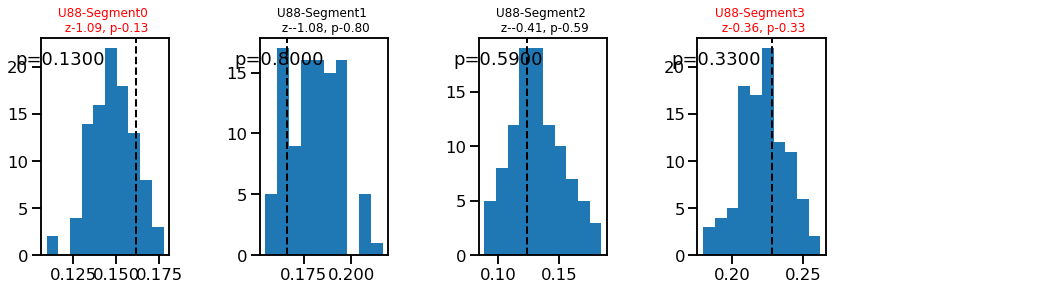

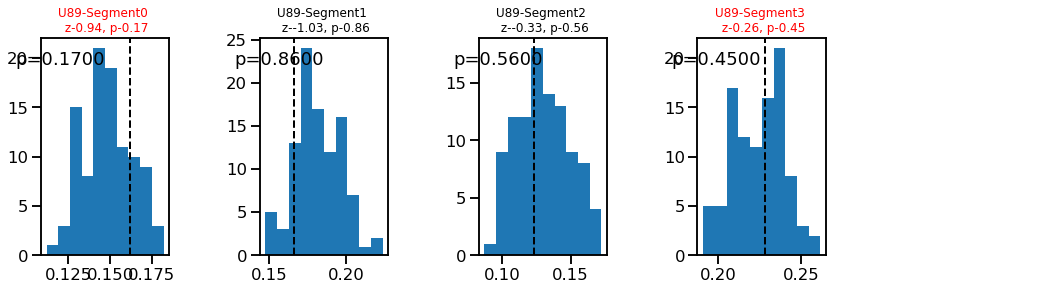

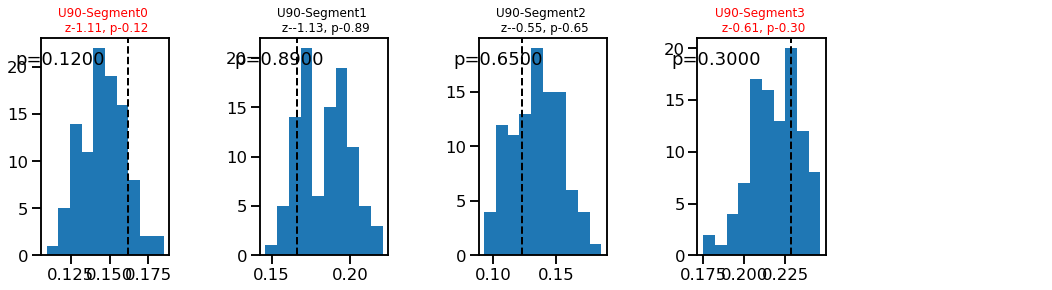

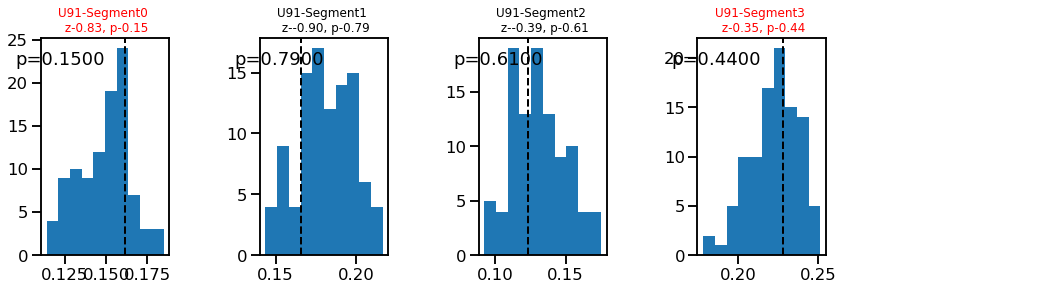

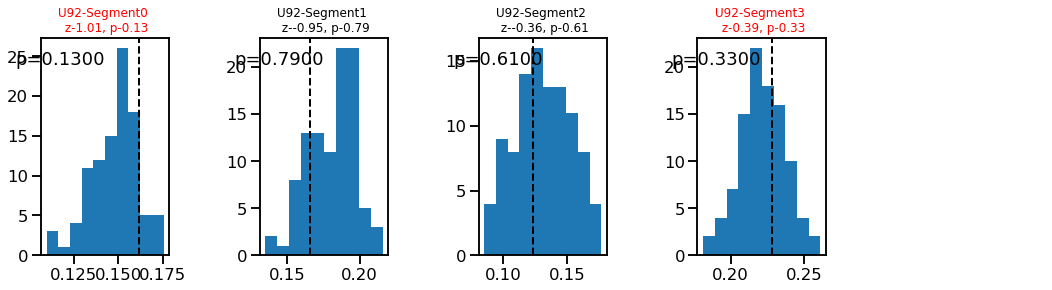

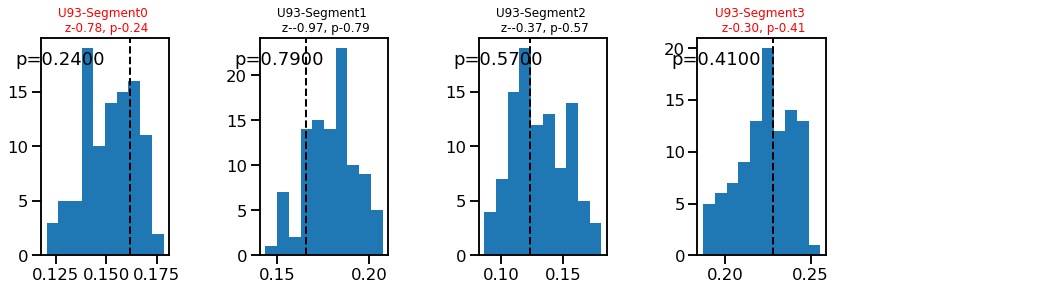

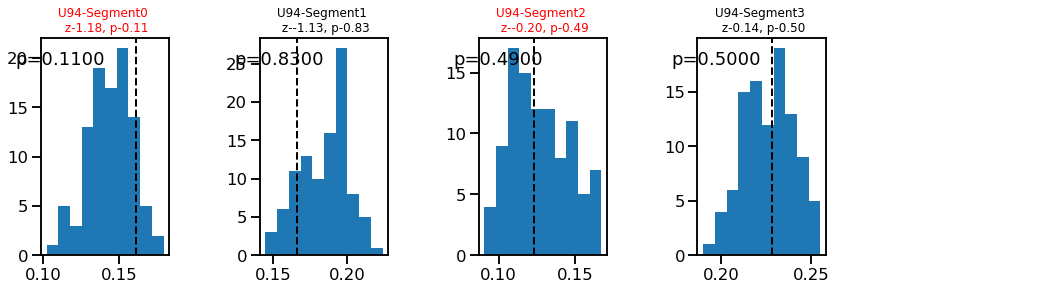

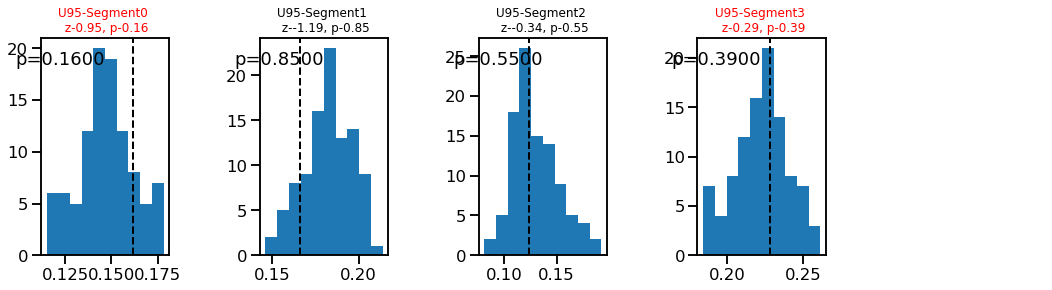

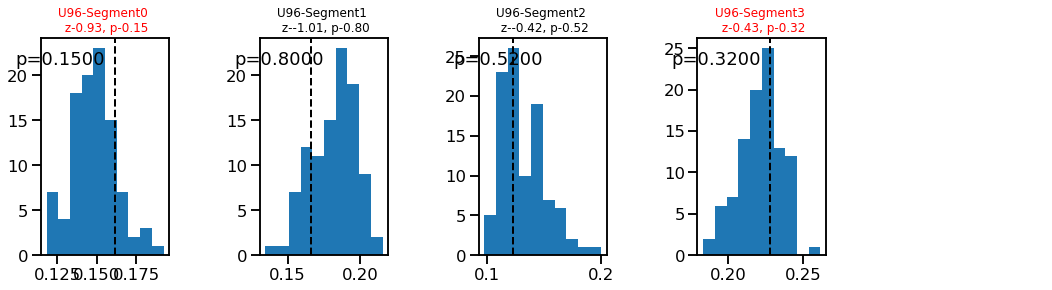

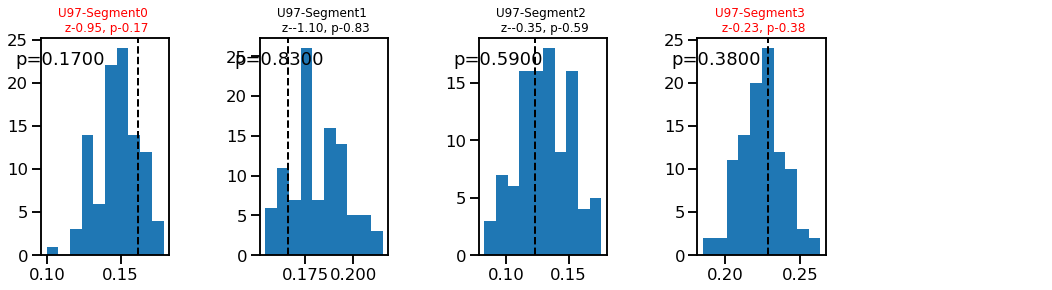

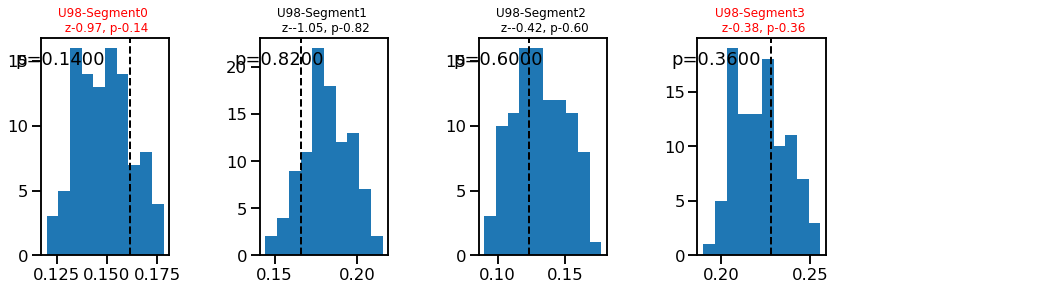

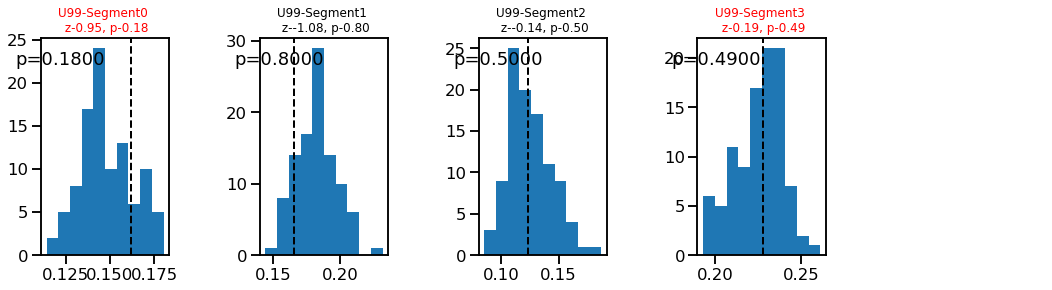

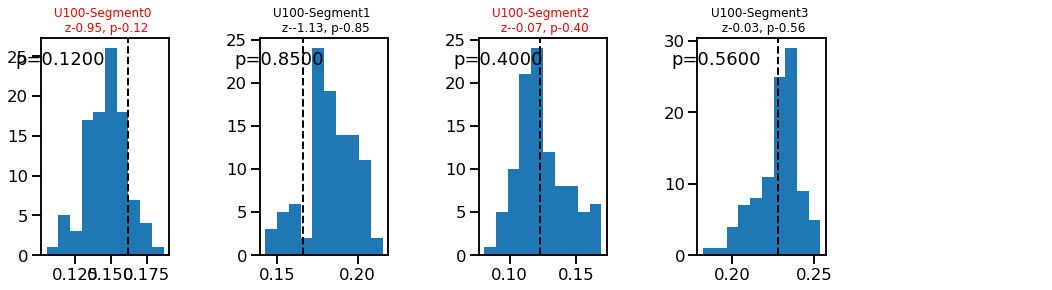

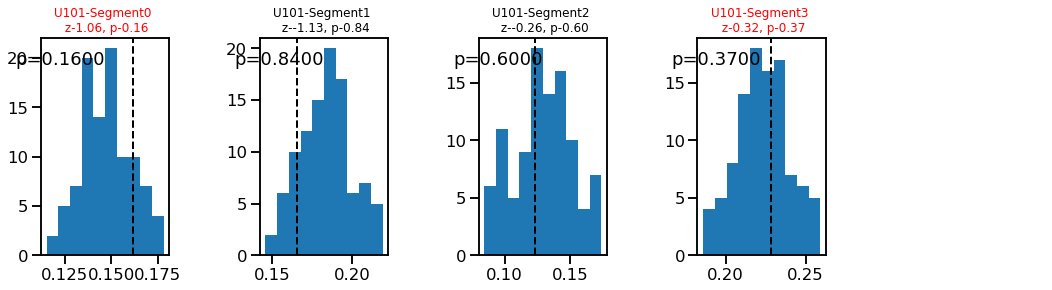

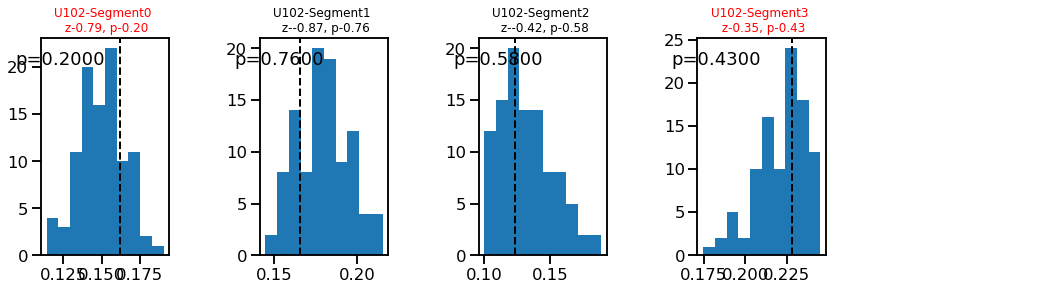

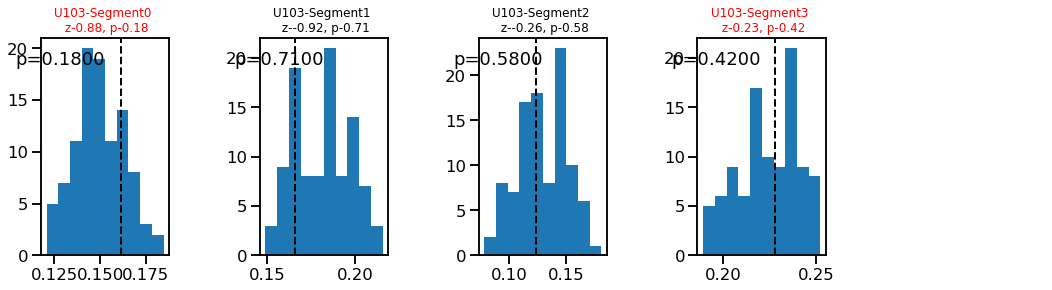

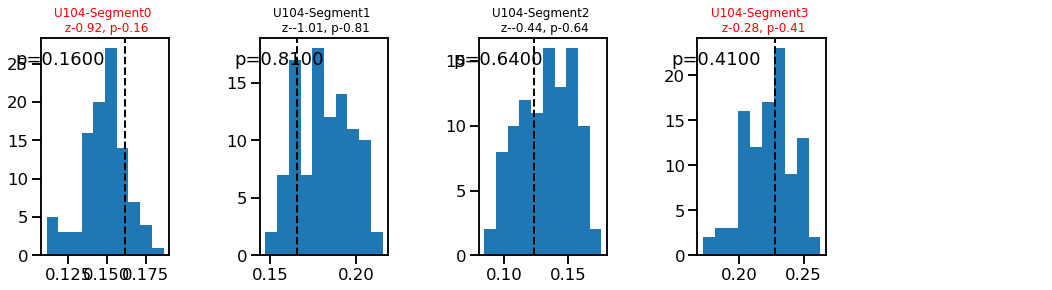

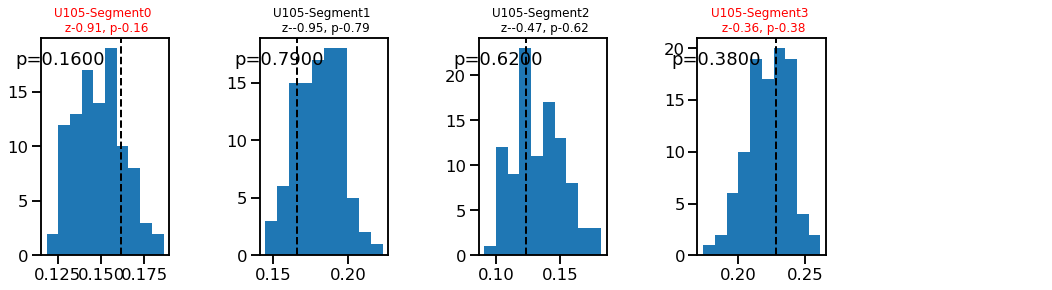

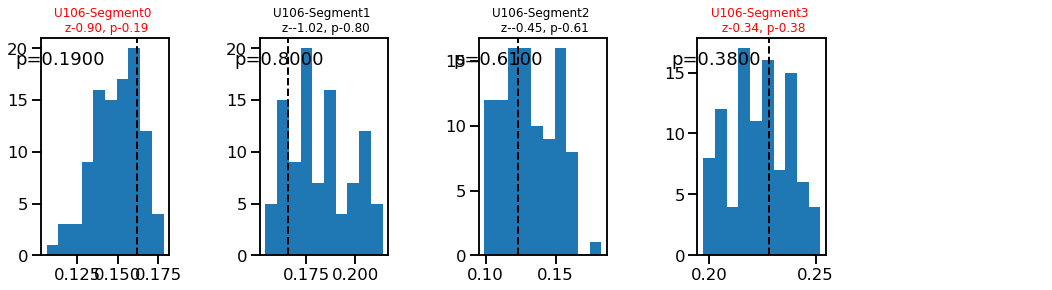

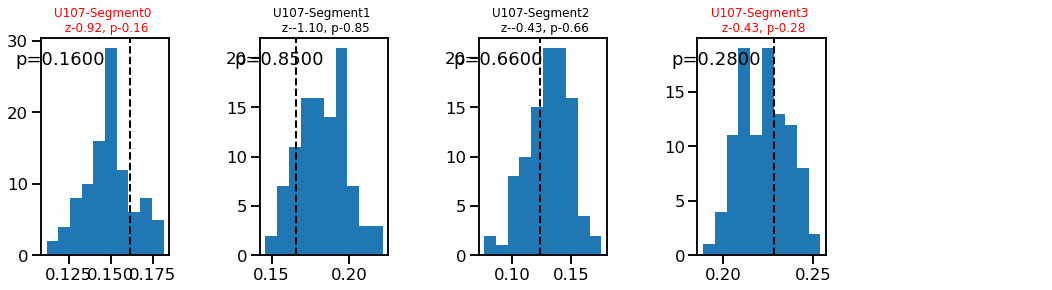

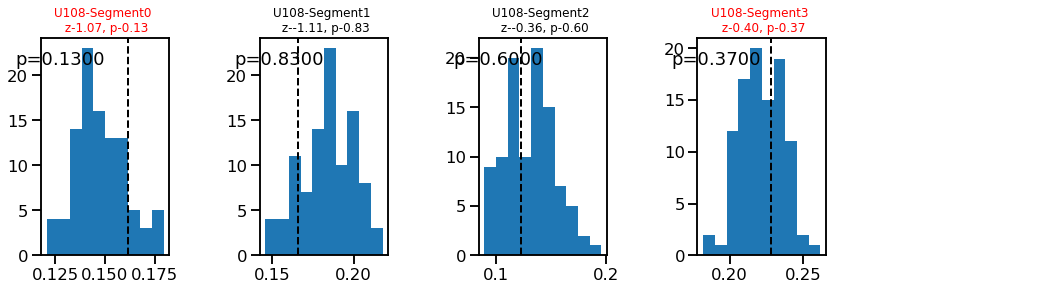

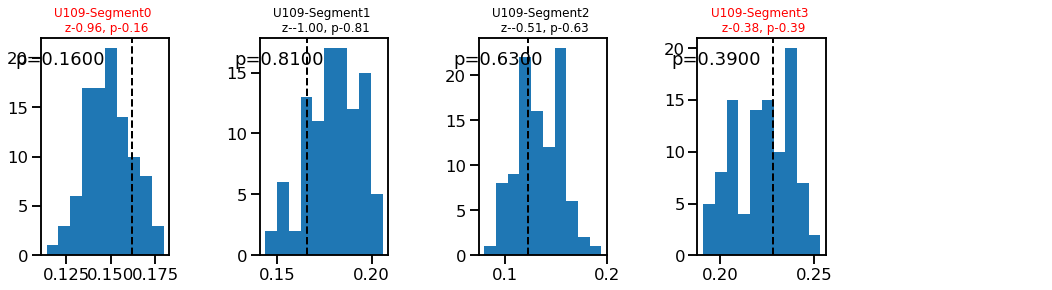

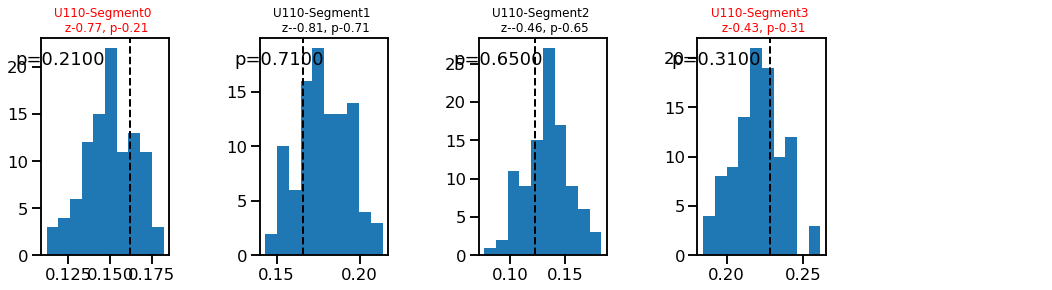

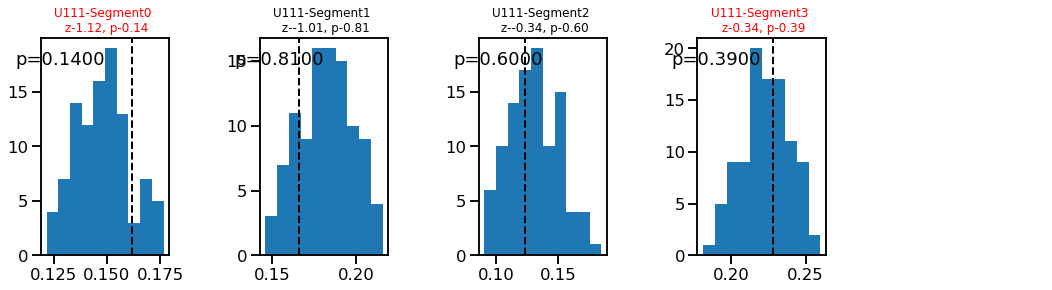

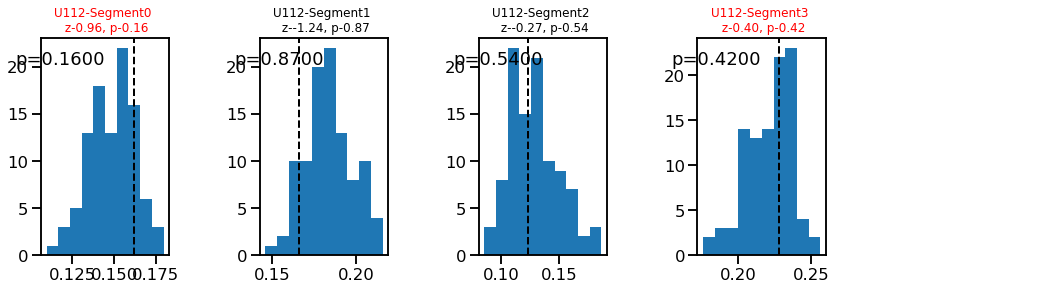

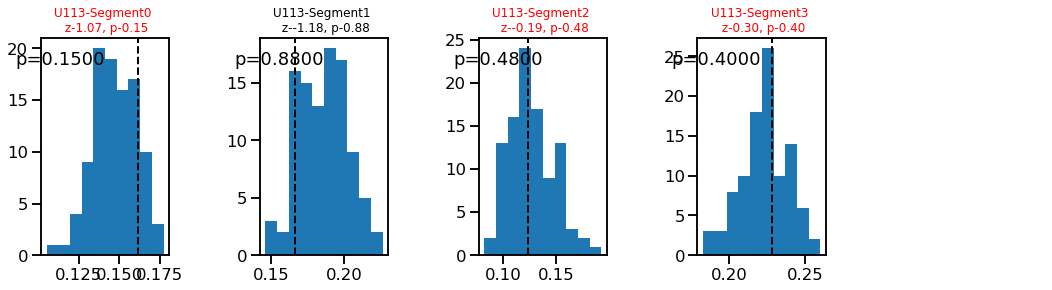

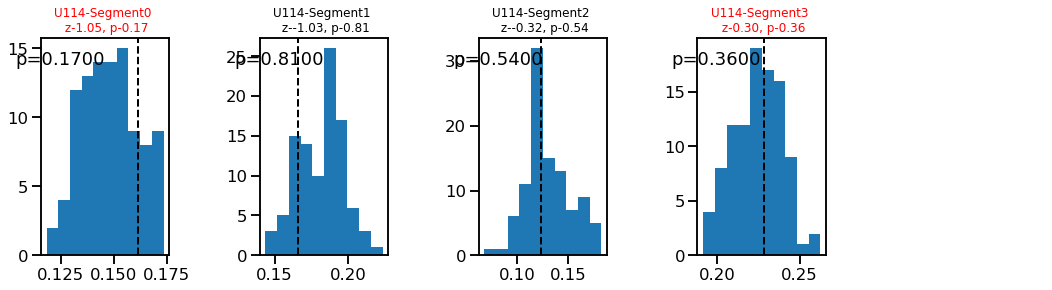

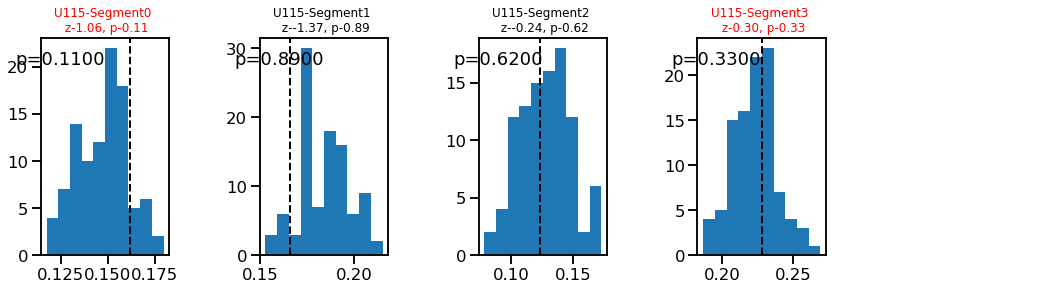

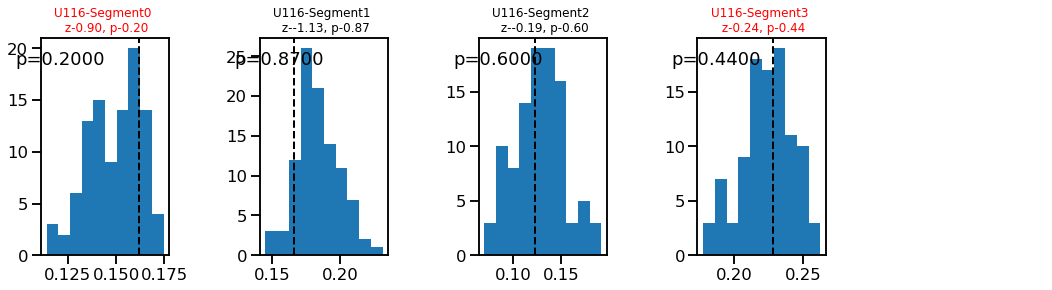

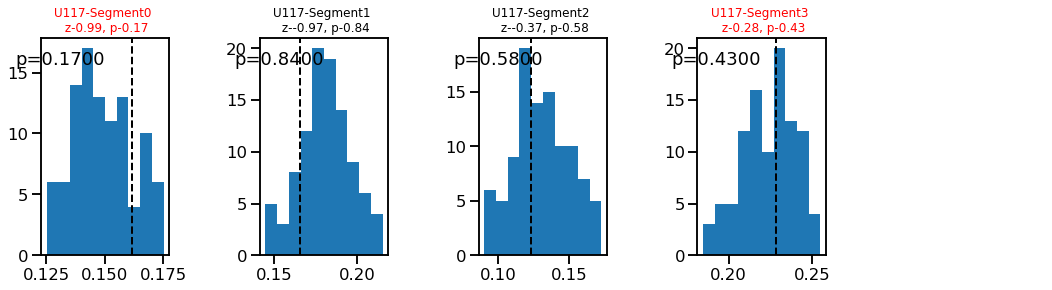

In [269]:
# Plot distribution of surrogates with measured empirical value per segment across trials for all units

for ii in range(n_units):
    spikes = nwbfile.units.get_unit_spike_times(uint) / 1000
    spikes = restrict_range(spikes, st, en)
    
    seg_times = np.diff(np.insert(ch_openings, 0, t_time[0]))
    
    # Count firing in each segment, and compute firing rate
    count = Counter({0 : 0, 1 : 0, 2 : 0, 3 : 0})
    count.update(np.digitize(t_spikes, ch_openings))
    inds = count.keys()
    frs = np.array(list(count.values())) / seg_times * 1000
    
    all_frs = compute_serial_position_fr(spikes, trial_starts, chest_openings, chest_trials, ptimes, positions)
    
    temp = spikes - st
    times_shuffle = shuffle_spikes(temp, shuffle_approach, n_surrogates)
    times_shuffle = times_shuffle + st
    
    # compute the firing rate per segement across trials on surrogates
    all_surrs = np.zeros(shape=[n_surrogates, 4])
    
    for ind, stimes in enumerate(times_shuffle):
        surrs_frs = compute_serial_position_fr(stimes, trial_starts, chest_openings, chest_trials, ptimes, positions) 
    
        # Take the mean across trials of shuffle n
        mean_surrs = np.mean(surrs_frs, 0)

        # Collect the mean of shuffle n
        all_surrs[ind] = mean_surrs
        
    # Compute the empirical p-value based on surrogates for each segment (seg1, seg2, seg3, seg4)
    surr_p_val_seg1 = compute_empirical_pvalue(all_frs.mean(0)[0],all_surrs[:,0])
    surr_p_val_seg2 = compute_empirical_pvalue(all_frs.mean(0)[1],all_surrs[:,1])
    surr_p_val_seg3 = compute_empirical_pvalue(all_frs.mean(0)[2],all_surrs[:,2])
    surr_p_val_seg4 = compute_empirical_pvalue(all_frs.mean(0)[3],all_surrs[:,3])

    # Compute z-score compared to surrogates for each segment (seg1, seg2, seg3, seg4)
    z_score_seg1 = zscore_to_surrogates(all_frs.mean(0)[0], all_surrs[:,0])
    z_score_seg2 = zscore_to_surrogates(all_frs.mean(0)[1], all_surrs[:,1])
    z_score_seg3 = zscore_to_surrogates(all_frs.mean(0)[2], all_surrs[:,2])
    z_score_seg4 = zscore_to_surrogates(all_frs.mean(0)[3], all_surrs[:,3])
    
    # Collect surr_p_val and z-score from each segment
    surr_p_val_all = np.array([surr_p_val_seg1,surr_p_val_seg2,surr_p_val_seg3,surr_p_val_seg4])
    z_score_all = np.array([z_score_seg1,z_score_seg2,z_score_seg3,z_score_seg4])
    
    # Plot firing rates per segment across all trials
    for jj, ax in zip(range(4), make_axes(4, hspace=0.2, wspace=0.7)):
        plot_surrogates(all_surrs[:,jj], all_frs.mean(0)[jj], surr_p_val_all[jj], ax=ax)

        color = 'red' if surr_p_val_all[jj] < 0.5 else 'black'
        title = 'U{}-Segment{} \n z-{:1.2f}, p-{:1.2f}'.format(ii, jj, z_score_all[jj], surr_p_val_all[jj])
        ax.set_title(title, fontdict={'fontsize' : 12}, color=color);